# Plotting cross section ratios as a function of Bjorken-x

In [2]:
import uproot
import numpy as np
import time
import matplotlib.pyplot as plt
import ROOT as r
from scipy.interpolate import griddata
from scipy import stats

Welcome to JupyROOT 6.28/04


\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{MC}
\end{equation}

In [15]:
start_time = time.time()
r.EnableImplicitMT()
folder = 'Be9'

ntg = 'Be9' #What is the nuclei in numerator?
dtg = 'LD2' #What is the nuclei in denominator?
ald = 'Dummy' #Aluminium dummy target
dang = 20.0 #What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] #What are your desired central momenta(just the magnitude)
cafe_report_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/reportfiles/'
tinfo_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/HMS_runlist copy.txt'
datafile_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/ROOTfiles/'
bin_num = 32 * len(dmom) #half percent bins according to the resolution of the spectrometer(-8% to 8%)
bin_eprime_low = 2.22
bin_eprime_high = bin_eprime_low + 0.0125 * bin_num
print("bin_eprime_high", bin_eprime_high)
Dummy_dict = {
    6.6: [4668, 4669],
    5.878: [4772, 4773, 4774, 4775, 4776],
    5.36: [4789],
    4.78: [4859],
    4.27: [4866],
    3.81: [4913],
    3.4: [4920],
    3.04: [4954],
    2.71: [4960],
    2.42: [5015, 5016]
}
LD2_dict = {
    6.6: [4662, 4663, 4664, 4665, 4666],
    5.878: [4780, 4781, 4782, 4783, 4784, 4785],
    5.36: [4786, 4787],
    4.78: [4862, 4863],
    4.27: [4864],
    3.81: [4915],
    3.4: [4918],
    3.04: [4956, 4957],
    2.71: [4958, 4962],
    2.42: [5019, 5020]
}
Be9_dict = {
    6.6: [4684, 4685, 4687, 4688, 4670],
    5.878: [4762, 4763, 4764, 4769, 4770, 4771],
    5.36: [4798, 4799, 4800, 4801, 4802, 4790],
    4.78: [4850, 4851, 4852, 4857, 4858],
    4.27: [4873, 4874, 4867],
    3.81: [4905, 4906, 4907, 4911, 4912],
    3.4: [4924, 4921],
    3.04: [4950],
    2.71: [4967, 4968],
    2.42: [5007, 5008]
}
target_dicts = {
    'Be9': Be9_dict,
    'LD2': LD2_dict,
    'Dummy': Dummy_dict
}

def csb(eprime, tg):
    if dang == 20.0:
        targ = ['C12', 'Ca40', 'Ag', 'Al', 'Au', 'Be9', 'B10', 'B11', 'Ca48', 'Cu', 'LD2', 'Dummy', 'Fe54', 'He3', 'He4', 'Li6', 'Li7', 'Ni58', 'Ni64', 'Sn*', 'Th', 'Ti']
        a_list = [1.766, 2.129, 1.904, 1.717, 1.789, 1.974, 1.798, 1.833, 2.218, 2.157, 2.763, 1.642, 1.723, 2.338, 2.307, 1.741, 1.845, 1.415, 1.423, None, 1.814, 1.600]
        b_list = [-2.185, -2.064, -1.951, -2.130, -1.938, -2.231, -2.206, -2.218, -2.036, -1.964, -2.423, -2.130, -2.072, -2.348, -2.278, -2.247, -2.311, -2.034, -2.037, None, -1.927, -2.103]
    if dang == 26.0:
        targ = ['C12', 'Ca40', 'LD2', 'Dummy']
        a_list = [2.244, 2.355, 3.324, 2.079]
        b_list = [-2.637, -2.338, -3.045, -2.538]
    if dang == 35.0:
        targ = ["C12", "Ca40", "Ca48", "LD2", "Dummy", "He3", "He4"]
        a_list = [2.286, 1.977, 1.917, 3.091, 2.126, 2.674, 2.627]
        b_list = [-2.935, -2.275, -2.183, -3.451, -2.778, -3.246, -3.120]
    if tg in targ:
        i = targ.index(tg)
        # print("i", i)
        a_pow = a_list[i]
        b_pow = b_list[i]
    else:
        print("Target not found")
    # print(f"csb for {tg}", "a_pow", a_pow, "b_pow", b_pow)
    csb = np.exp(a_pow + b_pow*eprime)
    csb = csb - csb
    return csb

# Function to read the text file into an array
def ImportRadcor(filename):
    vectors = [[] for _ in range(13)]
    with open(filename, 'r') as infile:
        for line in infile:
            if line.startswith(' *'):
                continue
            values = line.split()
            if len(values) == 13:
                for i, val in enumerate(values):
                    vectors[i].append(float(val))
    return [np.array(v) for v in vectors]

#Function to calculate scaling factors for data
def read_report(momentum, tg):
    q = j = 0
    ls = '2'
    sf = []
    target_dict = target_dicts.get(tg)
    # if target_dict:
    #     print(f"Target dictionary found for {tg}")
    for run in target_dict[momentum]:
        cafe_report = open(cafe_report_path+"replay_hms_production_%d_-1.report"%run)
        for line in cafe_report:
            if "BCM4A Beam Cut Charge" in line:
                c2 = float((line.split(":")[1]).strip()[:-2])
            if "_factor" in line:
                f1 = float((line.split("=")[-1].strip()))
                if f1 != -1.0 :
                    #print("Prescale factor:",f1)
                    ll = f1
                    f2 = str((line.split(["="][0])))
                    ls = f2[4]
                    #print("Active trigger",f2[4])
                    continue
            if "Ps%s HMS Computer Live Time"%ls in line:
                clt = float((line.split(":")[1]).strip()[:-3])
            if "BCM4A Beam Cut Current" in line:
                cc = float((line.split(":")[1]).strip()[:-2])
            if "E SING FID" in line:
                fid = float((line.split(":")[1]).strip()[:-11])
                c2o = c2 * (1 + 0.37/cc) #Beam current offset correction
                pro = c2o * clt * 0.01
                pro2 = pro * fid #Denominator for the CNY
                sf.append(pro2/ll) #Saving the scaling factors into a list
                j=j+1
                q=q+1
    tsf = sum(sf)
    p_scale = 1/tsf
    #Taking into account cryo target boiling
    if tg == 'LD2' or tg == 'LH2' or tg == 'He3' or tg == 'He4':
        p_scale = p_scale * (1 + (0.0006719 * cc))
        # print(f"Target boiling correction for cryo target {tg}", (1 + (0.0006719 * cc)))
    else:
        # print(f"No target boiling correction for solid target {tg}")
        pass
    return p_scale

def root_hist_to_numpy(root_hist):
    bin_edges = np.array([root_hist.GetXaxis().GetBinLowEdge(i) for i in range(1, root_hist.GetNbinsX() + 2)])
    bin_contents = np.array([root_hist.GetBinContent(i) for i in range(1, root_hist.GetNbinsX() + 1)])
    bin_errors = np.array([root_hist.GetBinError(i) for i in range(1, root_hist.GetNbinsX() + 1)])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, bin_contents, bin_errors

#Kinematic variables
ts = dang #Spectrometer angle
Z, A = 4, 9  #Target
density = 1.0 #Target density g/cm3
thick = 0.986 #g/cm2. From Cameron's target sheet column 'R'('H' for cryo targets)
ep_min = {}
ep_max = {}
#Constants
Ei, Mp = 10.54, 0.93825 #Beam energy and proton mass in GeV
N_A, Q_E = 6.02e+23, 1.60e-19 #Avogadro's number and charge in 1 electron
al_den, length = 2.699, 10. #Density of aluminum can and length of can
dpp_up, dpp_down = 15.0, -15.0 #Momentum acceptance upper and lower limit
cos_ts = np.cos(np.deg2rad(ts))
sin_ts = np.sin(np.deg2rad(ts))
for momentum in dmom:
    ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
    ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 110.0, -110.0, 65.0, -65.0 #mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  #diff solid angle in sr
    sim_charge = 1.
    wall_exit, wall_ent = 0.0168, 0.02024 #in cm
    dum_thick_exit, dum_thick_ent = 0.1816, 0.1815 #g/cm2
    hyd_thick_ent = al_den * wall_ent #g/cm2
    hyd_thick_exit = al_den * wall_exit #g/cm2
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
    ratio_ent = hyd_thick_ent / dum_thick_ent
    ratio_exit = hyd_thick_exit / dum_thick_exit

bin_eprime_high 6.220000000000001


<h1 align="center">DATA WORK FOR NTG</h1>

non zero indices of eprime_bin_contents_2p71 [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56]
Implicit multithreading is enabled, using 8 cores.


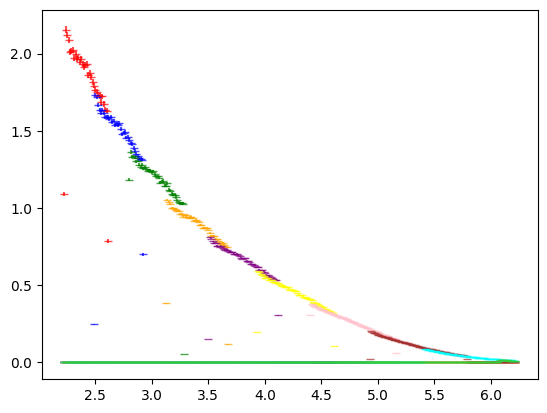

In [16]:
#Define the data cuts
data_cut = "-8 < H_gtr_dp && H_gtr_dp < 8 && H_cal_etottracknorm > 0.7 && abs(H_gtr_ph) < 0.032 && abs(H_gtr_th) < 0.085 && H_cer_npeSum > 2 && H_bcm_CurrentFlag == 1"

histograms = {}
for momentum in dmom:
    # print("momentum", momentum)
    #Create a TChain
    ch = r.TChain("T")

    for run in Be9_dict[momentum]:
        ch.Add(f'/Users/AbSir/Desktop/MC_Yield/ROOTfiles/HMS_{run}_skim.root')
    df = r.RDataFrame(ch)  #Create an RDataFrame from the TChain
    prod_scale = read_report(momentum, ntg)
    #Apply the cuts to the chained dataframe
    hc = df.Filter(data_cut)\
            .Define("Eprime", f"{momentum}*(1 + 0.01*H_gtr_dp)")
    
    #Create the histograms from the dataframe
    heprime = hc.Histo1D(("Eprime", "Eprime", bin_num, bin_eprime_low, bin_eprime_high), "Eprime")
    heprime.Sumw2()
    hdeltadat = hc.Histo1D(("Delta", "Delta", bin_num, -8.0, 8.0), "H_gtr_dp")
    hdeltadat.Sumw2()
    heprime.Scale(prod_scale)
    heprime_th = heprime.GetValue()
    histograms[momentum] = heprime_th.Clone()

#fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
fig, ax = plt.subplots()
eprime_bin_centers_2p42, eprime_bin_contents_2p42, eprime_bin_errors_2p42 = root_hist_to_numpy(histograms[2.42])
eprime_bin_centers_2p71, eprime_bin_contents_2p71, eprime_bin_errors_2p71 = root_hist_to_numpy(histograms[2.71])
eprime_bin_centers_3p04, eprime_bin_contents_3p04, eprime_bin_errors_3p04 = root_hist_to_numpy(histograms[3.04])
eprime_bin_centers_3p4, eprime_bin_contents_3p4, eprime_bin_errors_3p4 = root_hist_to_numpy(histograms[3.4])
eprime_bin_centers_3p81, eprime_bin_contents_3p81, eprime_bin_errors_3p81 = root_hist_to_numpy(histograms[3.81])
eprime_bin_centers_4p27, eprime_bin_contents_4p27, eprime_bin_errors_4p27 = root_hist_to_numpy(histograms[4.27])
eprime_bin_centers_4p78, eprime_bin_contents_4p78, eprime_bin_errors_4p78 = root_hist_to_numpy(histograms[4.78])
eprime_bin_centers_5p36, eprime_bin_contents_5p36, eprime_bin_errors_5p36 = root_hist_to_numpy(histograms[5.36])
eprime_bin_centers_5p878, eprime_bin_contents_5p878, eprime_bin_errors_5p878 = root_hist_to_numpy(histograms[5.878])
eprime_bin_centers_6p6, eprime_bin_contents_6p6, eprime_bin_errors_6p6 = root_hist_to_numpy(histograms[6.6])

prod_scale_2p42 = read_report(2.42, ntg)
prod_scale_2p71 = read_report(2.71, ntg)
prod_scale_3p04 = read_report(3.04, ntg)
prod_scale_3p4 = read_report(3.4, ntg)
prod_scale_3p81 = read_report(3.81, ntg)
prod_scale_4p27 = read_report(4.27, ntg)
prod_scale_4p78 = read_report(4.78, ntg)
prod_scale_5p36 = read_report(5.36, ntg)
prod_scale_5p878 = read_report(5.878, ntg)
prod_scale_6p6 = read_report(6.6, ntg)

#Perform charge symmetric background subtraction
csb_contents_2p42 = csb(eprime_bin_centers_2p42[eprime_bin_contents_2p42 != 0], ntg)
csb_contents_2p71 = csb(eprime_bin_centers_2p71[eprime_bin_contents_2p71 != 0], ntg)
csb_contents_3p04 = csb(eprime_bin_centers_3p04[eprime_bin_contents_3p04 != 0], ntg)
csb_contents_3p4 = csb(eprime_bin_centers_3p4[eprime_bin_contents_3p4 != 0], ntg)
csb_contents_3p81 = csb(eprime_bin_centers_3p81[eprime_bin_contents_3p81 != 0], ntg)
csb_contents_4p27 = csb(eprime_bin_centers_4p27[eprime_bin_contents_4p27 != 0], ntg)
csb_contents_4p78 = csb(eprime_bin_centers_4p78[eprime_bin_contents_4p78 != 0], ntg)
csb_contents_5p36 = csb(eprime_bin_centers_5p36[eprime_bin_contents_5p36 != 0], ntg)
csb_contents_5p878 = csb(eprime_bin_centers_5p878[eprime_bin_contents_5p878 != 0], ntg)
csb_contents_6p6 = csb(eprime_bin_centers_6p6[eprime_bin_contents_6p6 != 0], ntg)

print("non zero indices of eprime_bin_contents_2p71", np.nonzero(eprime_bin_contents_2p71)[0])
# print("ep_bin_contents_2p71", eprime_bin_contents_2p71)

# Initialize the resulting array with the original contents
subtracted_bin_contents_2p42 = np.array(eprime_bin_contents_2p42)
subtracted_bin_contents_2p71 = np.array(eprime_bin_contents_2p71)
subtracted_bin_contents_3p04 = np.array(eprime_bin_contents_3p04)
subtracted_bin_contents_3p4 = np.array(eprime_bin_contents_3p4)
subtracted_bin_contents_3p81 = np.array(eprime_bin_contents_3p81)
subtracted_bin_contents_4p27 = np.array(eprime_bin_contents_4p27)
subtracted_bin_contents_4p78 = np.array(eprime_bin_contents_4p78)
subtracted_bin_contents_5p36 = np.array(eprime_bin_contents_5p36)
subtracted_bin_contents_5p878 = np.array(eprime_bin_contents_5p878)
subtracted_bin_contents_6p6 = np.array(eprime_bin_contents_6p6)

# Find non-zero indices
non_zero_indices_2p42 = np.nonzero(eprime_bin_contents_2p42)[0]
non_zero_indices_2p71 = np.nonzero(eprime_bin_contents_2p71)[0]
non_zero_indices_3p04 = np.nonzero(eprime_bin_contents_3p04)[0]
non_zero_indices_3p4 = np.nonzero(eprime_bin_contents_3p4)[0]
non_zero_indices_3p81 = np.nonzero(eprime_bin_contents_3p81)[0]
non_zero_indices_4p27 = np.nonzero(eprime_bin_contents_4p27)[0]
non_zero_indices_4p78 = np.nonzero(eprime_bin_contents_4p78)[0]
non_zero_indices_5p36 = np.nonzero(eprime_bin_contents_5p36)[0]
non_zero_indices_5p878 = np.nonzero(eprime_bin_contents_5p878)[0]
non_zero_indices_6p6 = np.nonzero(eprime_bin_contents_6p6)[0]

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
# Perform the subtraction only at non-zero indices
    subtracted_bin_contents_2p42[non_zero_indices_2p42] -= csb_contents_2p42 * prod_scale_2p42
    subtracted_bin_contents_2p71[non_zero_indices_2p71] -= csb_contents_2p71 * prod_scale_2p71
    subtracted_bin_contents_3p04[non_zero_indices_3p04] -= csb_contents_3p04 * prod_scale_3p04
    subtracted_bin_contents_3p4[non_zero_indices_3p4] -= csb_contents_3p4 * prod_scale_3p4
    subtracted_bin_contents_3p81[non_zero_indices_3p81] -= csb_contents_3p81 * prod_scale_3p81
    subtracted_bin_contents_4p27[non_zero_indices_4p27] -= csb_contents_4p27 * prod_scale_4p27
    subtracted_bin_contents_4p78[non_zero_indices_4p78] -= csb_contents_4p78 * prod_scale_4p78
    subtracted_bin_contents_5p36[non_zero_indices_5p36] -= csb_contents_5p36 * prod_scale_5p36
    subtracted_bin_contents_5p878[non_zero_indices_5p878] -= csb_contents_5p878 * prod_scale_5p878
    subtracted_bin_contents_6p6[non_zero_indices_6p6] -= csb_contents_6p6 * prod_scale_6p6
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

subtracted_bin_errors_2p42 = np.array(eprime_bin_errors_2p42)
subtracted_bin_errors_2p71 = np.array(eprime_bin_errors_2p71)
subtracted_bin_errors_3p04 = np.array(eprime_bin_errors_3p04)
subtracted_bin_errors_3p4 = np.array(eprime_bin_errors_3p4)
subtracted_bin_errors_3p81 = np.array(eprime_bin_errors_3p81)
subtracted_bin_errors_4p27 = np.array(eprime_bin_errors_4p27)
subtracted_bin_errors_4p78 = np.array(eprime_bin_errors_4p78)
subtracted_bin_errors_5p36 = np.array(eprime_bin_errors_5p36)
subtracted_bin_errors_5p878 = np.array(eprime_bin_errors_5p878)
subtracted_bin_errors_6p6 = np.array(eprime_bin_errors_6p6)

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
    subtracted_bin_errors_2p42[non_zero_indices_2p42] = np.sqrt(subtracted_bin_errors_2p42[non_zero_indices_2p42]**2 + (csb_contents_2p42 * prod_scale_2p42)**2)
    subtracted_bin_errors_2p71[non_zero_indices_2p71] = np.sqrt(subtracted_bin_errors_2p71[non_zero_indices_2p71]**2 + (csb_contents_2p71 * prod_scale)**2)
    subtracted_bin_errors_3p04[non_zero_indices_3p04] = np.sqrt(subtracted_bin_errors_3p04[non_zero_indices_3p04]**2 + (csb_contents_3p04 * prod_scale_3p04)**2)
    subtracted_bin_errors_3p4[non_zero_indices_3p4] = np.sqrt(subtracted_bin_errors_3p4[non_zero_indices_3p4]**2 + (csb_contents_3p4 * prod_scale_3p4)**2)
    subtracted_bin_errors_3p81[non_zero_indices_3p81] = np.sqrt(subtracted_bin_errors_3p81[non_zero_indices_3p81]**2 + (csb_contents_3p81 * prod_scale_3p81)**2)
    subtracted_bin_errors_4p27[non_zero_indices_4p27] = np.sqrt(subtracted_bin_errors_4p27[non_zero_indices_4p27]**2 + (csb_contents_4p27 * prod_scale_4p27)**2)
    subtracted_bin_errors_4p78[non_zero_indices_4p78] = np.sqrt(subtracted_bin_errors_4p78[non_zero_indices_4p78]**2 + (csb_contents_4p78 * prod_scale_4p78)**2)
    subtracted_bin_errors_5p36[non_zero_indices_5p36] = np.sqrt(subtracted_bin_errors_5p36[non_zero_indices_5p36]**2 + (csb_contents_5p36 * prod_scale_5p36)**2)
    subtracted_bin_errors_5p878[non_zero_indices_5p878] = np.sqrt(subtracted_bin_errors_5p878[non_zero_indices_5p878]**2 + (csb_contents_5p878 * prod_scale_5p878)**2)
    subtracted_bin_errors_6p6[non_zero_indices_6p6] = np.sqrt(subtracted_bin_errors_6p6[non_zero_indices_6p6]**2 + (csb_contents_6p6 * prod_scale_6p6)**2)
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

ax.errorbar(eprime_bin_centers_2p42, subtracted_bin_contents_2p42, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV') 
ax.errorbar(eprime_bin_centers_2p71, subtracted_bin_contents_2p71, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax.errorbar(eprime_bin_centers_3p04, subtracted_bin_contents_3p04, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax.errorbar(eprime_bin_centers_3p4, subtracted_bin_contents_3p4, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
ax.errorbar(eprime_bin_centers_3p81, subtracted_bin_contents_3p81, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
ax.errorbar(eprime_bin_centers_4p27, subtracted_bin_contents_4p27, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
ax.errorbar(eprime_bin_centers_4p78, subtracted_bin_contents_4p78, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
ax.errorbar(eprime_bin_centers_5p36, subtracted_bin_contents_5p36, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
ax.errorbar(eprime_bin_centers_5p878, subtracted_bin_contents_5p878, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax.errorbar(eprime_bin_centers_6p6, subtracted_bin_contents_6p6, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')

# Check if IMT is enabled
if r.IsImplicitMTEnabled():
    nthreads = r.ROOT.GetThreadPoolSize()
    print(f"Implicit multithreading is enabled, using {nthreads} cores.")
else:
    print("Implicit MT is not enabled.")

<h1 align="center">SIMULATION WORK FOR NTG</h1>


In [17]:
#Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_20degberyllium22_hms.out")

#Fixing the binning for the simulation histograms
hseprime_min = bin_eprime_low
hseprime_max = bin_eprime_high
hseprime_num_bins = bin_num
hseprime_binwidth = (hseprime_max - hseprime_min) / hseprime_num_bins
hseprime_binedges = np.linspace(hseprime_min, hseprime_max, hseprime_num_bins + 1)

Eprime_dict = {}
xsec_array = {}
mc_scale = {}
for momentum in dmom:
    string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    filepath = f"/Users/AbSir/Desktop/MC_Yield/ROOTfiles/hms_mc_be_20degm{string}.root"
    file = uproot.open(filepath)
    tree = file["h1"]

    # Load the branches
    electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library='np')    
    nentries = len(electrons["hsdelta"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
            (np.abs(electrons["hsyptar"]) < 0.032) & \
            (np.abs(electrons["hsxptar"]) < 0.085) & \
            (electrons["stop_id"] == 0)

    #Perform the delta correction
    electrons["hsdelta"] = (0.991333 * electrons["hsdelta"]) - 0.0026865 * (electrons["hsdelta"]**2) + 0.00023225 * (electrons["hsdelta"]**3) + 0.00001006 * (electrons["hsdelta"]**4) - 1.96515E-6 * (electrons["hsdelta"]**5) + 8.42355E-8 * (electrons["hsdelta"]**6)
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdelta"][mc_cut]
    hsyptar_cut = electrons["hsyptar"][mc_cut]
    hsxptar_cut = electrons["hsxptar"][mc_cut]

    # Calculate E' and theta(in degrees)
    Eprime_dict[momentum] = momentum*(1 + 0.01*hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut*sin_ts)/np.sqrt(1 + hsxptar_cut*hsxptar_cut + hsyptar_cut*hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
    xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method='linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation

#This function returns 2 arrays: bin counts(the counts in each bin taking weights into account) and bin edges(the edges of the bins)
bin_counts_eprime_2p42, bin_edges_eprime_2p42 = np.histogram(Eprime_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hseprime_binedges)
bin_counts_eprime_2p71, bin_edges_eprime_2p71 = np.histogram(Eprime_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hseprime_binedges)
bin_counts_eprime_3p04, bin_edges_eprime_3p04 = np.histogram(Eprime_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hseprime_binedges)
bin_counts_eprime_3p4, bin_edges_eprime_3p4 = np.histogram(Eprime_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hseprime_binedges)
bin_counts_eprime_3p81, bin_edges_eprime_3p81 = np.histogram(Eprime_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hseprime_binedges)
bin_counts_eprime_4p27, bin_edges_eprime_4p27 = np.histogram(Eprime_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hseprime_binedges)
bin_counts_eprime_4p78, bin_edges_eprime_4p78 = np.histogram(Eprime_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hseprime_binedges)
bin_counts_eprime_5p36, bin_edges_eprime_5p36 = np.histogram(Eprime_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hseprime_binedges)
bin_counts_eprime_5p878, bin_edges_eprime_5p878 = np.histogram(Eprime_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hseprime_binedges)
bin_counts_eprime_6p6, bin_edges_eprime_6p6 = np.histogram(Eprime_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hseprime_binedges)
#bin_sqares contains the square of the error for each bin
bin_squares_eprime_2p42, _ = np.histogram(Eprime_dict[2.42], weights = (xsec_array[2.42] * mc_scale[2.42])**2, bins = hseprime_binedges)
bin_squares_eprime_2p71, _ = np.histogram(Eprime_dict[2.71], weights = (xsec_array[2.71] * mc_scale[2.71])**2, bins = hseprime_binedges)
bin_squares_eprime_3p04, _ = np.histogram(Eprime_dict[3.04], weights = (xsec_array[3.04] * mc_scale[3.04])**2, bins = hseprime_binedges)
bin_squares_eprime_3p4, _ = np.histogram(Eprime_dict[3.4], weights = (xsec_array[3.4] * mc_scale[3.4])**2, bins = hseprime_binedges)
bin_squares_eprime_3p81, _ = np.histogram(Eprime_dict[3.81], weights = (xsec_array[3.81] * mc_scale[3.81])**2, bins = hseprime_binedges)
bin_squares_eprime_4p27, _ = np.histogram(Eprime_dict[4.27], weights = (xsec_array[4.27] * mc_scale[4.27])**2, bins = hseprime_binedges)
bin_squares_eprime_4p78, _ = np.histogram(Eprime_dict[4.78], weights = (xsec_array[4.78] * mc_scale[4.78])**2, bins = hseprime_binedges)
bin_squares_eprime_5p36, _ = np.histogram(Eprime_dict[5.36], weights = (xsec_array[5.36] * mc_scale[5.36])**2, bins = hseprime_binedges)
bin_squares_eprime_5p878, _ = np.histogram(Eprime_dict[5.878], weights = (xsec_array[5.878] * mc_scale[5.878])**2, bins = hseprime_binedges)
bin_squares_eprime_6p6, _ = np.histogram(Eprime_dict[6.6], weights = (xsec_array[6.6] * mc_scale[6.6])**2, bins = hseprime_binedges)
#Calculating the actual error for each bin
bin_errors_eprime_2p42 = np.sqrt(bin_squares_eprime_2p42)
bin_errors_eprime_2p71 = np.sqrt(bin_squares_eprime_2p71)
bin_errors_eprime_3p04 = np.sqrt(bin_squares_eprime_3p04)
bin_errors_eprime_3p4 = np.sqrt(bin_squares_eprime_3p4)
bin_errors_eprime_3p81 = np.sqrt(bin_squares_eprime_3p81)
bin_errors_eprime_4p27 = np.sqrt(bin_squares_eprime_4p27)
bin_errors_eprime_4p78 = np.sqrt(bin_squares_eprime_4p78)
bin_errors_eprime_5p36 = np.sqrt(bin_squares_eprime_5p36)
bin_errors_eprime_5p878 = np.sqrt(bin_squares_eprime_5p878)
bin_errors_eprime_6p6 = np.sqrt(bin_squares_eprime_6p6)
#The bin centers are calculated for plotting purposes. bin_edges[:-1] is all bin edges except the last, and bin_edges[1:] is all bin edges except the first.
bin_centers_eprime_2p42 = (bin_edges_eprime_2p42[:-1] + bin_edges_eprime_2p42[1:]) / 2
bin_centers_eprime_2p71 = (bin_edges_eprime_2p71[:-1] + bin_edges_eprime_2p71[1:]) / 2
bin_centers_eprime_3p04 = (bin_edges_eprime_3p04[:-1] + bin_edges_eprime_3p04[1:]) / 2
bin_centers_eprime_3p4 = (bin_edges_eprime_3p4[:-1] + bin_edges_eprime_3p4[1:]) / 2
bin_centers_eprime_3p81 = (bin_edges_eprime_3p81[:-1] + bin_edges_eprime_3p81[1:]) / 2
bin_centers_eprime_4p27 = (bin_edges_eprime_4p27[:-1] + bin_edges_eprime_4p27[1:]) / 2
bin_centers_eprime_4p78 = (bin_edges_eprime_4p78[:-1] + bin_edges_eprime_4p78[1:]) / 2
bin_centers_eprime_5p36 = (bin_edges_eprime_5p36[:-1] + bin_edges_eprime_5p36[1:]) / 2
bin_centers_eprime_5p878 = (bin_edges_eprime_5p878[:-1] + bin_edges_eprime_5p878[1:]) / 2
bin_centers_eprime_6p6 = (bin_edges_eprime_6p6[:-1] + bin_edges_eprime_6p6[1:]) / 2

#Plotting the histogram with error bars
ax.errorbar(bin_centers_eprime_2p42, bin_counts_eprime_2p42, yerr = bin_errors_eprime_2p42, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax.errorbar(bin_centers_eprime_2p71, bin_counts_eprime_2p71, yerr = bin_errors_eprime_2p71, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.71 GeV')
ax.errorbar(bin_centers_eprime_3p04, bin_counts_eprime_3p04, yerr = bin_errors_eprime_3p04, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.04 GeV')
ax.errorbar(bin_centers_eprime_3p4, bin_counts_eprime_3p4, yerr = bin_errors_eprime_3p4, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.4 GeV')
ax.errorbar(bin_centers_eprime_3p81, bin_counts_eprime_3p81, yerr = bin_errors_eprime_3p81, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.81 GeV')
ax.errorbar(bin_centers_eprime_4p27, bin_counts_eprime_4p27, yerr = bin_errors_eprime_4p27, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.27 GeV')
ax.errorbar(bin_centers_eprime_4p78, bin_counts_eprime_4p78, yerr = bin_errors_eprime_4p78, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.78 GeV')
ax.errorbar(bin_centers_eprime_5p36, bin_counts_eprime_5p36, yerr = bin_errors_eprime_5p36, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.36 GeV')
ax.errorbar(bin_centers_eprime_5p878, bin_counts_eprime_5p878, yerr = bin_errors_eprime_5p878, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.878 GeV')
ax.errorbar(bin_centers_eprime_6p6, bin_counts_eprime_6p6, yerr = bin_errors_eprime_6p6, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 6.6 GeV')
ax.grid(True, alpha = 0.2)
ax.set_xlabel('Eprime')
ax.set_ylabel('Yield')
ax.set_yscale('log')
# ax.legend() 
ax.set_title(f'{ntg} @{dang}˚')
fig.savefig(f'{folder}/eprime_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/684221695.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/684221695.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/684221695.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/684221695.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/684221695.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p4 = eprime_bin_contents_3p4/bin_counts_ep

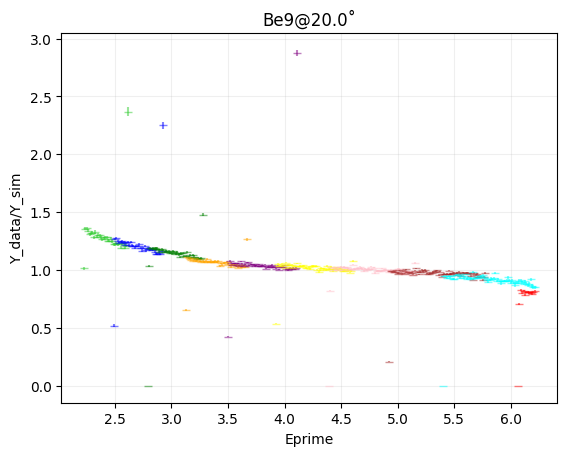

In [18]:
ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
ratio_eprime_3p4 = eprime_bin_contents_3p4/bin_counts_eprime_3p4
ratio_eprime_3p81 = eprime_bin_contents_3p81/bin_counts_eprime_3p81
ratio_eprime_4p27 = eprime_bin_contents_4p27/bin_counts_eprime_4p27
ratio_eprime_4p78 = eprime_bin_contents_4p78/bin_counts_eprime_4p78
ratio_eprime_5p36 = eprime_bin_contents_5p36/bin_counts_eprime_5p36
ratio_eprime_5p878 = eprime_bin_contents_5p878/bin_counts_eprime_5p878
ratio_eprime_6p6 = eprime_bin_contents_6p6/bin_counts_eprime_6p6

ratio_errors_2p42 = ratio_eprime_2p42 * np.sqrt((eprime_bin_errors_2p42/eprime_bin_contents_2p42)**2 + (bin_errors_eprime_2p42/bin_counts_eprime_2p42)**2)
ratio_errors_2p71 = ratio_eprime_2p71 * np.sqrt((eprime_bin_errors_2p71/eprime_bin_contents_2p71)**2 + (bin_errors_eprime_2p71/bin_counts_eprime_2p71)**2)
ratio_errors_3p04 = ratio_eprime_3p04 * np.sqrt((eprime_bin_errors_3p04/eprime_bin_contents_3p04)**2 + (bin_errors_eprime_3p04/bin_counts_eprime_3p04)**2)
ratio_errors_3p4 = ratio_eprime_3p4 * np.sqrt((eprime_bin_errors_3p4/eprime_bin_contents_3p4)**2 + (bin_errors_eprime_3p4/bin_counts_eprime_3p4)**2)
ratio_errors_3p81 = ratio_eprime_3p81 * np.sqrt((eprime_bin_errors_3p81/eprime_bin_contents_3p81)**2 + (bin_errors_eprime_3p81/bin_counts_eprime_3p81)**2)
ratio_errors_4p27 = ratio_eprime_4p27 * np.sqrt((eprime_bin_errors_4p27/eprime_bin_contents_4p27)**2 + (bin_errors_eprime_4p27/bin_counts_eprime_4p27)**2)
ratio_errors_4p78 = ratio_eprime_4p78 * np.sqrt((eprime_bin_errors_4p78/eprime_bin_contents_4p78)**2 + (bin_errors_eprime_4p78/bin_counts_eprime_4p78)**2)
ratio_errors_5p36 = ratio_eprime_5p36 * np.sqrt((eprime_bin_errors_5p36/eprime_bin_contents_5p36)**2 + (bin_errors_eprime_5p36/bin_counts_eprime_5p36)**2)
ratio_errors_5p878 = ratio_eprime_5p878 * np.sqrt((eprime_bin_errors_5p878/eprime_bin_contents_5p878)**2 + (bin_errors_eprime_5p878/bin_counts_eprime_5p878)**2)
ratio_errors_6p6 = ratio_eprime_6p6 * np.sqrt((eprime_bin_errors_6p6/eprime_bin_contents_6p6)**2 + (bin_errors_eprime_6p6/bin_counts_eprime_6p6)**2)

fig2, ax2 = plt.subplots()
ax2.errorbar(bin_centers_eprime_2p42, ratio_eprime_2p42, yerr = ratio_errors_2p42, fmt = '_', alpha = 0.5, color = 'limegreen', label = '2.42 GeV')
ax2.errorbar(bin_centers_eprime_2p71, ratio_eprime_2p71, yerr = ratio_errors_2p71, fmt = '_', alpha = 0.5, color = 'blue', label = '2.71 GeV')
ax2.errorbar(bin_centers_eprime_3p04, ratio_eprime_3p04, yerr = ratio_errors_3p04, fmt = '_', alpha = 0.5, color = 'green', label = '3.04 GeV')
ax2.errorbar(bin_centers_eprime_3p4, ratio_eprime_3p4, yerr = ratio_errors_3p4, fmt = '_', alpha = 0.5, color = 'orange', label = '3.4 GeV')
ax2.errorbar(bin_centers_eprime_3p81, ratio_eprime_3p81, yerr = ratio_errors_3p81, fmt = '_', alpha = 0.5, color = 'purple', label = '3.81 GeV')
ax2.errorbar(bin_centers_eprime_4p27, ratio_eprime_4p27, yerr = ratio_errors_4p27, fmt = '_', alpha = 0.5, color = 'yellow', label = '4.27 GeV')
ax2.errorbar(bin_centers_eprime_4p78, ratio_eprime_4p78, yerr = ratio_errors_4p78, fmt = '_', alpha = 0.5, color = 'pink', label = '4.78 GeV')
ax2.errorbar(bin_centers_eprime_5p36, ratio_eprime_5p36, yerr = ratio_errors_5p36, fmt = '_', alpha = 0.5, color = 'brown', label = '5.36 GeV')
ax2.errorbar(bin_centers_eprime_5p878, ratio_eprime_5p878, yerr = ratio_errors_5p878, fmt = '_', alpha = 0.5, color = 'cyan', label = '5.878 GeV')
ax2.errorbar(bin_centers_eprime_6p6, ratio_eprime_6p6, yerr = ratio_errors_6p6, fmt = '_', alpha = 0.5, color = 'red', label = '6.6 GeV')
ax2.set_xlabel('Eprime')
ax2.set_ylabel('Y_data/Y_sim')
ax2.set_title(f'{ntg}@{dang}˚')
ax2.grid(True, alpha = 0.2)
ax.set_ylim(0.9,1.1)
fig2.savefig(f'{folder}/yieldratio_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR NTG</h1>


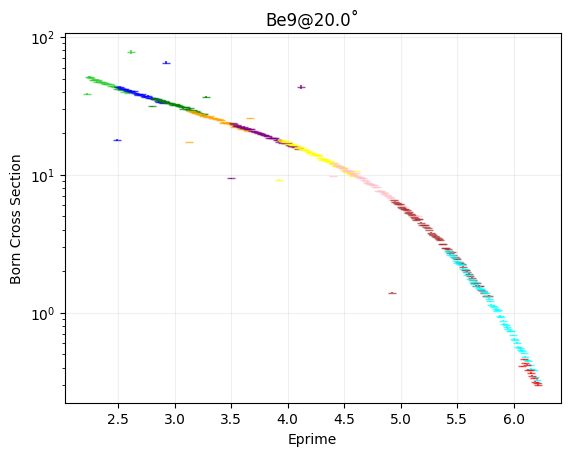

In [19]:
points_to_interpolate_2p42 = np.column_stack((bin_centers_eprime_2p42, np.full(len(bin_centers_eprime_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((bin_centers_eprime_2p71, np.full(len(bin_centers_eprime_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((bin_centers_eprime_3p04, np.full(len(bin_centers_eprime_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((bin_centers_eprime_3p4, np.full(len(bin_centers_eprime_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((bin_centers_eprime_3p81, np.full(len(bin_centers_eprime_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((bin_centers_eprime_4p27, np.full(len(bin_centers_eprime_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((bin_centers_eprime_4p78, np.full(len(bin_centers_eprime_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((bin_centers_eprime_5p36, np.full(len(bin_centers_eprime_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((bin_centers_eprime_5p878, np.full(len(bin_centers_eprime_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((bin_centers_eprime_6p6, np.full(len(bin_centers_eprime_6p6), dang)))

born_xsec_array_2p42 = griddata(points, V6, points_to_interpolate_2p42, method='linear')
born_xsec_array_2p71 = griddata(points, V6, points_to_interpolate_2p71, method='linear')
born_xsec_array_3p04 = griddata(points, V6, points_to_interpolate_3p04, method='linear')
born_xsec_array_3p4 = griddata(points, V6, points_to_interpolate_3p4, method='linear')
born_xsec_array_3p81 = griddata(points, V6, points_to_interpolate_3p81, method='linear')
born_xsec_array_4p27 = griddata(points, V6, points_to_interpolate_4p27, method='linear')
born_xsec_array_4p78 = griddata(points, V6, points_to_interpolate_4p78, method='linear')
born_xsec_array_5p36 = griddata(points, V6, points_to_interpolate_5p36, method='linear')
born_xsec_array_5p878 = griddata(points, V6, points_to_interpolate_5p878, method='linear')
born_xsec_array_6p6 = griddata(points, V6, points_to_interpolate_6p6, method='linear')

fig3, ax3 = plt.subplots()
born_cross_2p42_ntg = ratio_eprime_2p42 * born_xsec_array_2p42
born_cross_2p71_ntg = ratio_eprime_2p71 * born_xsec_array_2p71
born_cross_3p04_ntg = ratio_eprime_3p04 * born_xsec_array_3p04
born_cross_3p4_ntg= ratio_eprime_3p4 * born_xsec_array_3p4
born_cross_3p81_ntg = ratio_eprime_3p81 * born_xsec_array_3p81
born_cross_4p27_ntg = ratio_eprime_4p27 * born_xsec_array_4p27
born_cross_4p78_ntg = ratio_eprime_4p78 * born_xsec_array_4p78
born_cross_5p36_ntg = ratio_eprime_5p36 * born_xsec_array_5p36
born_cross_5p878_ntg = ratio_eprime_5p878 * born_xsec_array_5p878
born_cross_6p6_ntg= ratio_eprime_6p6 * born_xsec_array_6p6

born_errors_2p42_ntg = born_cross_2p42_ntg * ratio_errors_2p42
born_errors_2p71_ntg = born_cross_2p71_ntg * ratio_errors_2p71
born_errors_3p04_ntg = born_cross_3p04_ntg * ratio_errors_3p04
born_errors_3p4_ntg = born_cross_3p4_ntg * ratio_errors_3p4
born_errors_3p81_ntg = born_cross_3p81_ntg * ratio_errors_3p81
born_errors_4p27_ntg = born_cross_4p27_ntg * ratio_errors_4p27
born_errors_4p78_ntg = born_cross_4p78_ntg * ratio_errors_4p78
born_errors_5p36_ntg = born_cross_5p36_ntg * ratio_errors_5p36
born_errors_5p878_ntg = born_cross_5p878_ntg * ratio_errors_5p878
born_errors_6p6_ntg = born_cross_6p6_ntg * ratio_errors_6p6

ax3.errorbar(bin_centers_eprime_2p42, born_cross_2p42_ntg, yerr = born_errors_2p42_ntg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax3.errorbar(bin_centers_eprime_2p71, born_cross_2p71_ntg, yerr = born_errors_2p71_ntg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax3.errorbar(bin_centers_eprime_3p04, born_cross_3p04_ntg, yerr = born_errors_3p04_ntg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax3.errorbar(bin_centers_eprime_3p4, born_cross_3p4_ntg, yerr = born_errors_3p4_ntg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax3.errorbar(bin_centers_eprime_3p81, born_cross_3p81_ntg, yerr = born_errors_3p81_ntg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax3.errorbar(bin_centers_eprime_4p27, born_cross_4p27_ntg, yerr = born_errors_4p27_ntg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax3.errorbar(bin_centers_eprime_4p78, born_cross_4p78_ntg, yerr = born_errors_4p78_ntg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax3.errorbar(bin_centers_eprime_5p36, born_cross_5p36_ntg, yerr = born_errors_5p36_ntg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax3.errorbar(bin_centers_eprime_5p878, born_cross_5p878_ntg, yerr = born_errors_5p878_ntg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax3.errorbar(bin_centers_eprime_6p6, born_cross_6p6_ntg, yerr = born_errors_6p6_ntg, fmt = '_', alpha = 0.7, color = 'red', label = '6.6 GeV')
ax3.set_xlabel('Eprime')
ax3.set_ylabel('Born Cross Section')
ax3.set_title(f'{ntg}@{dang}˚')
ax3.set_yscale('log')
#ax3.legend()
ax3.grid(True, alpha = 0.2)
fig3.savefig(f'{folder}/xsec_{ntg}_{dang}_{start_time:.0f}.pdf')


<h1 align="center">DATA WORK FOR DUMMY TARGET</h1>


In [20]:
Z, A = 13, 27 #Target
thick = 0.24 #Target thickness in g/cm^2
E = 0.19535 #Ratio of dummy to target cell thickness
lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

for momentum in dmom:
    ch = r.TChain("T")
    for run in Dummy_dict[momentum]:
        ch.Add(f'/Users/AbSir/Desktop/MC_Yield/ROOTfiles/HMS_{run}_skim.root')
    df = r.RDataFrame(ch)
    prod_scale = read_report(momentum, ald)
    hc = df.Filter(data_cut)\
            .Define("Eprime", f"{momentum}*(1 + 0.01*H_gtr_dp)")
    heprime = hc.Histo1D(("Eprime", "Eprime", bin_num, bin_eprime_low, bin_eprime_high), "Eprime")
    heprime.Sumw2()
    heprime.Scale(prod_scale)
    heprime_th = heprime.GetValue()
    histograms[momentum] = heprime_th.Clone()

_, dummy_eprime_bin_contents_2p42, dummy_eprime_bin_errors_2p42 = root_hist_to_numpy(histograms[2.42])
_, dummy_eprime_bin_contents_2p71, dummy_eprime_bin_errors_2p71 = root_hist_to_numpy(histograms[2.71])
_, dummy_eprime_bin_contents_3p04, dummy_eprime_bin_errors_3p04 = root_hist_to_numpy(histograms[3.04])
_, dummy_eprime_bin_contents_3p4, dummy_eprime_bin_errors_3p4 = root_hist_to_numpy(histograms[3.4])
_, dummy_eprime_bin_contents_3p81, dummy_eprime_bin_errors_3p81 = root_hist_to_numpy(histograms[3.81])
_, dummy_eprime_bin_contents_4p27, dummy_eprime_bin_errors_4p27 = root_hist_to_numpy(histograms[4.27])
_, dummy_eprime_bin_contents_4p78, dummy_eprime_bin_errors_4p78 = root_hist_to_numpy(histograms[4.78])
_, dummy_eprime_bin_contents_5p36, dummy_eprime_bin_errors_5p36 = root_hist_to_numpy(histograms[5.36])
_, dummy_eprime_bin_contents_5p878, dummy_eprime_bin_errors_5p878 = root_hist_to_numpy(histograms[5.878])
_, dummy_eprime_bin_contents_6p6, dummy_eprime_bin_errors_6p6 = root_hist_to_numpy(histograms[6.6])

<h1 align="center">DATA WORK FOR DTG</h1>


non zero indices of eprime_bin_contents_2p71 [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56]


<ErrorbarContainer object of 3 artists>

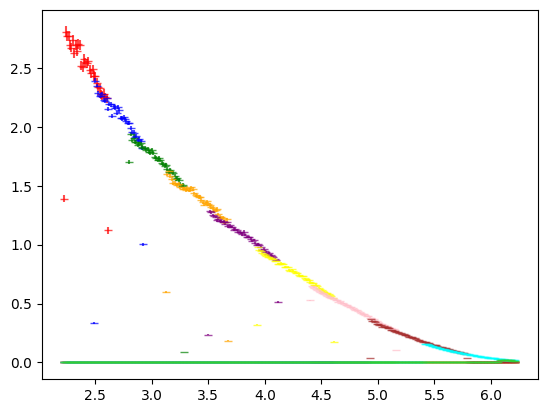

In [21]:
#Kinematic variables
Z, A = 1, 2  #Target
thick = 1.6698 #g/cm2. From Cameron's target sheet column 'R'('H' for cryo targets)
thick = thick * 0.996 #Cryo target contraction correction factor
lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

for momentum in dmom:
    # print("momentum", momentum)
    #Create a TChain
    ch = r.TChain("T")

    for run in LD2_dict[momentum]:
        ch.Add(f'/Users/AbSir/Desktop/MC_Yield/ROOTfiles/HMS_{run}_skim.root')
    df = r.RDataFrame(ch)  #Create an RDataFrame from the TChain
    prod_scale = read_report(momentum, dtg)
    #Apply the cuts to the chained dataframe
    hc = df.Filter(data_cut)\
        .Define("Eprime", f"{momentum}*(1 + 0.01*H_gtr_dp)")
    
    #Create the histograms from the dataframe
    heprime = hc.Histo1D(("Eprime", "Eprime", bin_num, bin_eprime_low, bin_eprime_high), "Eprime")
    heprime.Sumw2()
    hdeltadat = hc.Histo1D(("Delta", "Delta", bin_num, -8.0, 8.0), "H_gtr_dp")
    hdeltadat.Sumw2()
    # print("Total entries in data histogram", heprime.GetEntries())
    heprime.Scale(prod_scale)
    # print(f"prod_scale for {momentum} GeV", prod_scale)
    # print(type(heprime),"heprime type")
    heprime_th = heprime.GetValue()
    histograms[momentum] = heprime_th.Clone()

fig4, ax4 = plt.subplots()
eprime_bin_centers_2p42, eprime_bin_contents_2p42, eprime_bin_errors_2p42 = root_hist_to_numpy(histograms[2.42])
eprime_bin_centers_2p71, eprime_bin_contents_2p71, eprime_bin_errors_2p71 = root_hist_to_numpy(histograms[2.71])
eprime_bin_centers_3p04, eprime_bin_contents_3p04, eprime_bin_errors_3p04 = root_hist_to_numpy(histograms[3.04])
eprime_bin_centers_3p4, eprime_bin_contents_3p4, eprime_bin_errors_3p4 = root_hist_to_numpy(histograms[3.4])
eprime_bin_centers_3p81, eprime_bin_contents_3p81, eprime_bin_errors_3p81 = root_hist_to_numpy(histograms[3.81])
eprime_bin_centers_4p27, eprime_bin_contents_4p27, eprime_bin_errors_4p27 = root_hist_to_numpy(histograms[4.27])
eprime_bin_centers_4p78, eprime_bin_contents_4p78, eprime_bin_errors_4p78 = root_hist_to_numpy(histograms[4.78])
eprime_bin_centers_5p36, eprime_bin_contents_5p36, eprime_bin_errors_5p36 = root_hist_to_numpy(histograms[5.36])
eprime_bin_centers_5p878, eprime_bin_contents_5p878, eprime_bin_errors_5p878 = root_hist_to_numpy(histograms[5.878])
eprime_bin_centers_6p6, eprime_bin_contents_6p6, eprime_bin_errors_6p6 = root_hist_to_numpy(histograms[6.6])

# Perform Dummy Subtraction
eprime_bin_contents_2p42 = eprime_bin_contents_2p42 - E * dummy_eprime_bin_contents_2p42
eprime_bin_contents_2p71 = eprime_bin_contents_2p71 - E * dummy_eprime_bin_contents_2p71
eprime_bin_contents_3p04 = eprime_bin_contents_3p04 - E * dummy_eprime_bin_contents_3p04
eprime_bin_contents_3p4 = eprime_bin_contents_3p4 - E * dummy_eprime_bin_contents_3p4
eprime_bin_contents_3p81 = eprime_bin_contents_3p81 - E * dummy_eprime_bin_contents_3p81
eprime_bin_contents_4p27 = eprime_bin_contents_4p27 - E * dummy_eprime_bin_contents_4p27
eprime_bin_contents_4p78 = eprime_bin_contents_4p78 - E * dummy_eprime_bin_contents_4p78
eprime_bin_contents_5p36 = eprime_bin_contents_5p36 - E * dummy_eprime_bin_contents_5p36
eprime_bin_contents_5p878 = eprime_bin_contents_5p878 - E * dummy_eprime_bin_contents_5p878
eprime_bin_contents_6p6 = eprime_bin_contents_6p6 - E * dummy_eprime_bin_contents_6p6

#Error Prpoagation
eprime_bin_errors_2p42 = np.sqrt((eprime_bin_errors_2p42)**2 + (dummy_eprime_bin_errors_2p42)**2)
eprime_bin_errors_2p71 = np.sqrt((eprime_bin_errors_2p71)**2 + (dummy_eprime_bin_errors_2p71)**2)
eprime_bin_errors_3p04 = np.sqrt((eprime_bin_errors_3p04)**2 + (dummy_eprime_bin_errors_3p04)**2)
eprime_bin_errors_3p4 = np.sqrt((eprime_bin_errors_3p4)**2 + (dummy_eprime_bin_errors_3p4)**2)
eprime_bin_errors_3p81 = np.sqrt((eprime_bin_errors_3p81)**2 + (dummy_eprime_bin_errors_3p81)**2)
eprime_bin_errors_4p27 = np.sqrt((eprime_bin_errors_4p27)**2 + (dummy_eprime_bin_errors_4p27)**2)
eprime_bin_errors_4p78 = np.sqrt((eprime_bin_errors_4p78)**2 + (dummy_eprime_bin_errors_4p78)**2)
eprime_bin_errors_5p36 = np.sqrt((eprime_bin_errors_5p36)**2 + (dummy_eprime_bin_errors_5p36)**2)
eprime_bin_errors_5p878 = np.sqrt((eprime_bin_errors_5p878)**2 + (dummy_eprime_bin_errors_5p878)**2)
eprime_bin_errors_6p6 = np.sqrt((eprime_bin_errors_6p6)**2 + (dummy_eprime_bin_errors_6p6)**2)

prod_scale_2p42 = read_report(2.42, dtg)
prod_scale_2p71 = read_report(2.71, dtg)
prod_scale_3p04 = read_report(3.04, dtg)
prod_scale_3p4 = read_report(3.4, dtg)
prod_scale_3p81 = read_report(3.81, dtg)
prod_scale_4p27 = read_report(4.27, dtg)
prod_scale_4p78 = read_report(4.78, dtg)
prod_scale_5p36 = read_report(5.36, dtg)
prod_scale_5p878 = read_report(5.878, dtg)
prod_scale_6p6 = read_report(6.6, dtg)

#Perform charge symmetric background subtraction
csb_contents_2p42 = csb(eprime_bin_centers_2p42[eprime_bin_contents_2p42 != 0], dtg)
csb_contents_2p71 = csb(eprime_bin_centers_2p71[eprime_bin_contents_2p71 != 0], dtg)
csb_contents_3p04 = csb(eprime_bin_centers_3p04[eprime_bin_contents_3p04 != 0], dtg)
csb_contents_3p4 = csb(eprime_bin_centers_3p4[eprime_bin_contents_3p4 != 0], dtg)
csb_contents_3p81 = csb(eprime_bin_centers_3p81[eprime_bin_contents_3p81 != 0], dtg)
csb_contents_4p27 = csb(eprime_bin_centers_4p27[eprime_bin_contents_4p27 != 0], dtg)
csb_contents_4p78 = csb(eprime_bin_centers_4p78[eprime_bin_contents_4p78 != 0], dtg)
csb_contents_5p36 = csb(eprime_bin_centers_5p36[eprime_bin_contents_5p36 != 0], dtg)
csb_contents_5p878 = csb(eprime_bin_centers_5p878[eprime_bin_contents_5p878 != 0], dtg)
csb_contents_6p6 = csb(eprime_bin_centers_6p6[eprime_bin_contents_6p6 != 0], dtg)

print("non zero indices of eprime_bin_contents_2p71", np.nonzero(eprime_bin_contents_2p71)[0])
# print("ep_bin_contents_2p71", eprime_bin_contents_2p71)

# Initialize the resulting array with the original contents
subtracted_bin_contents_2p42 = np.array(eprime_bin_contents_2p42)
subtracted_bin_contents_2p71 = np.array(eprime_bin_contents_2p71)
subtracted_bin_contents_3p04 = np.array(eprime_bin_contents_3p04)
subtracted_bin_contents_3p4 = np.array(eprime_bin_contents_3p4)
subtracted_bin_contents_3p81 = np.array(eprime_bin_contents_3p81)
subtracted_bin_contents_4p27 = np.array(eprime_bin_contents_4p27)
subtracted_bin_contents_4p78 = np.array(eprime_bin_contents_4p78)
subtracted_bin_contents_5p36 = np.array(eprime_bin_contents_5p36)
subtracted_bin_contents_5p878 = np.array(eprime_bin_contents_5p878)
subtracted_bin_contents_6p6 = np.array(eprime_bin_contents_6p6)

# Find non-zero indices
non_zero_indices_2p42 = np.nonzero(eprime_bin_contents_2p42)[0]
non_zero_indices_2p71 = np.nonzero(eprime_bin_contents_2p71)[0]
non_zero_indices_3p04 = np.nonzero(eprime_bin_contents_3p04)[0]
non_zero_indices_3p4 = np.nonzero(eprime_bin_contents_3p4)[0]
non_zero_indices_3p81 = np.nonzero(eprime_bin_contents_3p81)[0]
non_zero_indices_4p27 = np.nonzero(eprime_bin_contents_4p27)[0]
non_zero_indices_4p78 = np.nonzero(eprime_bin_contents_4p78)[0]
non_zero_indices_5p36 = np.nonzero(eprime_bin_contents_5p36)[0]
non_zero_indices_5p878 = np.nonzero(eprime_bin_contents_5p878)[0]
non_zero_indices_6p6 = np.nonzero(eprime_bin_contents_6p6)[0]

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
# Perform the subtraction only at non-zero indices
    subtracted_bin_contents_2p42[non_zero_indices_2p42] -= csb_contents_2p42 * prod_scale_2p42
    subtracted_bin_contents_2p71[non_zero_indices_2p71] -= csb_contents_2p71 * prod_scale_2p71
    subtracted_bin_contents_3p04[non_zero_indices_3p04] -= csb_contents_3p04 * prod_scale_3p04
    subtracted_bin_contents_3p4[non_zero_indices_3p4] -= csb_contents_3p4 * prod_scale_3p4
    subtracted_bin_contents_3p81[non_zero_indices_3p81] -= csb_contents_3p81 * prod_scale_3p81
    subtracted_bin_contents_4p27[non_zero_indices_4p27] -= csb_contents_4p27 * prod_scale_4p27
    subtracted_bin_contents_4p78[non_zero_indices_4p78] -= csb_contents_4p78 * prod_scale_4p78
    subtracted_bin_contents_5p36[non_zero_indices_5p36] -= csb_contents_5p36 * prod_scale_5p36
    subtracted_bin_contents_5p878[non_zero_indices_5p878] -= csb_contents_5p878 * prod_scale_5p878
    subtracted_bin_contents_6p6[non_zero_indices_6p6] -= csb_contents_6p6 * prod_scale_6p6
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

subtracted_bin_errors_2p42 = np.array(eprime_bin_errors_2p42)
subtracted_bin_errors_2p71 = np.array(eprime_bin_errors_2p71)
subtracted_bin_errors_3p04 = np.array(eprime_bin_errors_3p04)
subtracted_bin_errors_3p4 = np.array(eprime_bin_errors_3p4)
subtracted_bin_errors_3p81 = np.array(eprime_bin_errors_3p81)
subtracted_bin_errors_4p27 = np.array(eprime_bin_errors_4p27)
subtracted_bin_errors_4p78 = np.array(eprime_bin_errors_4p78)
subtracted_bin_errors_5p36 = np.array(eprime_bin_errors_5p36)
subtracted_bin_errors_5p878 = np.array(eprime_bin_errors_5p878)
subtracted_bin_errors_6p6 = np.array(eprime_bin_errors_6p6)

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
    subtracted_bin_errors_2p42[non_zero_indices_2p42] = np.sqrt(subtracted_bin_errors_2p42[non_zero_indices_2p42]**2 + (csb_contents_2p42 * prod_scale_2p42)**2)
    subtracted_bin_errors_2p71[non_zero_indices_2p71] = np.sqrt(subtracted_bin_errors_2p71[non_zero_indices_2p71]**2 + (csb_contents_2p71 * prod_scale)**2)
    subtracted_bin_errors_3p04[non_zero_indices_3p04] = np.sqrt(subtracted_bin_errors_3p04[non_zero_indices_3p04]**2 + (csb_contents_3p04 * prod_scale_3p04)**2)
    subtracted_bin_errors_3p4[non_zero_indices_3p4] = np.sqrt(subtracted_bin_errors_3p4[non_zero_indices_3p4]**2 + (csb_contents_3p4 * prod_scale_3p4)**2)
    subtracted_bin_errors_3p81[non_zero_indices_3p81] = np.sqrt(subtracted_bin_errors_3p81[non_zero_indices_3p81]**2 + (csb_contents_3p81 * prod_scale_3p81)**2)
    subtracted_bin_errors_4p27[non_zero_indices_4p27] = np.sqrt(subtracted_bin_errors_4p27[non_zero_indices_4p27]**2 + (csb_contents_4p27 * prod_scale_4p27)**2)
    subtracted_bin_errors_4p78[non_zero_indices_4p78] = np.sqrt(subtracted_bin_errors_4p78[non_zero_indices_4p78]**2 + (csb_contents_4p78 * prod_scale_4p78)**2)
    subtracted_bin_errors_5p36[non_zero_indices_5p36] = np.sqrt(subtracted_bin_errors_5p36[non_zero_indices_5p36]**2 + (csb_contents_5p36 * prod_scale_5p36)**2)
    subtracted_bin_errors_5p878[non_zero_indices_5p878] = np.sqrt(subtracted_bin_errors_5p878[non_zero_indices_5p878]**2 + (csb_contents_5p878 * prod_scale_5p878)**2)
    subtracted_bin_errors_6p6[non_zero_indices_6p6] = np.sqrt(subtracted_bin_errors_6p6[non_zero_indices_6p6]**2 + (csb_contents_6p6 * prod_scale_6p6)**2)
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

ax4.errorbar(eprime_bin_centers_2p42, subtracted_bin_contents_2p42, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV') 
ax4.errorbar(eprime_bin_centers_2p71, subtracted_bin_contents_2p71, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax4.errorbar(eprime_bin_centers_3p04, subtracted_bin_contents_3p04, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax4.errorbar(eprime_bin_centers_3p4, subtracted_bin_contents_3p4, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
ax4.errorbar(eprime_bin_centers_3p81, subtracted_bin_contents_3p81, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
ax4.errorbar(eprime_bin_centers_4p27, subtracted_bin_contents_4p27, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
ax4.errorbar(eprime_bin_centers_4p78, subtracted_bin_contents_4p78, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
ax4.errorbar(eprime_bin_centers_5p36, subtracted_bin_contents_5p36, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
ax4.errorbar(eprime_bin_centers_5p878, subtracted_bin_contents_5p878, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax4.errorbar(eprime_bin_centers_6p6, subtracted_bin_contents_6p6, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')

<h1 align="center">SIMULATION WORK FOR DTG</h1>


In [22]:
#Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_20degd2cryo22_hms.out")

for momentum in dmom:
    string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    filepath = f"/Users/AbSir/Desktop/MC_Yield/ROOTfiles/hms_mc_d2_20degm{string}.root"
    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h1"]

    # Load the branches
    electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library='np')    
    nentries = len(electrons["hsdelta"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
            (np.abs(electrons["hsyptar"]) < 0.032) & \
            (np.abs(electrons["hsxptar"]) < 0.085) & \
            (electrons["stop_id"] == 0)
    
    #Perform the delta correction
    electrons["hsdelta"] = (0.991333 * electrons["hsdelta"]) - 0.0026865 * (electrons["hsdelta"]**2) + 0.00023225 * (electrons["hsdelta"]**3) + 0.00001006 * (electrons["hsdelta"]**4) - 1.96515E-6 * (electrons["hsdelta"]**5) + 8.42355E-8 * (electrons["hsdelta"]**6)
    
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdelta"][mc_cut]
    hsyptar_cut = electrons["hsyptar"][mc_cut]
    hsxptar_cut = electrons["hsxptar"][mc_cut]

    # Calculate E' and theta(in degrees)
    Eprime_dict[momentum] = momentum*(1 + 0.01*hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut*sin_ts)/np.sqrt(1 + hsxptar_cut*hsxptar_cut + hsyptar_cut*hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points = np.array([V2, V3]).T #Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))  #Make a column stack of points to be interpolated for our given E' and theta
    xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method='linear') #Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation
    # mc_scale[momentum] = mc_scale[momentum] * 1.55 #Ad hoc factor to get correct looking graphs. *Need to be removed later*

#This function returns 2 arrays: bin counts(the counts in each bin taking weights into account) and bin edges(the edges of the bins)
bin_counts_eprime_2p42, bin_edges_eprime_2p42 = np.histogram(Eprime_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hseprime_binedges)
bin_counts_eprime_2p71, bin_edges_eprime_2p71 = np.histogram(Eprime_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hseprime_binedges)
bin_counts_eprime_3p04, bin_edges_eprime_3p04 = np.histogram(Eprime_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hseprime_binedges)
bin_counts_eprime_3p4, bin_edges_eprime_3p4 = np.histogram(Eprime_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hseprime_binedges)
bin_counts_eprime_3p81, bin_edges_eprime_3p81 = np.histogram(Eprime_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hseprime_binedges)
bin_counts_eprime_4p27, bin_edges_eprime_4p27 = np.histogram(Eprime_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hseprime_binedges)
bin_counts_eprime_4p78, bin_edges_eprime_4p78 = np.histogram(Eprime_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hseprime_binedges)
bin_counts_eprime_5p36, bin_edges_eprime_5p36 = np.histogram(Eprime_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hseprime_binedges)
bin_counts_eprime_5p878, bin_edges_eprime_5p878 = np.histogram(Eprime_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hseprime_binedges)
bin_counts_eprime_6p6, bin_edges_eprime_6p6 = np.histogram(Eprime_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hseprime_binedges)
#bin_sqares contains the square of the error for each bin
bin_squares_eprime_2p42, _ = np.histogram(Eprime_dict[2.42], weights = (xsec_array[2.42] * mc_scale[2.42])**2, bins = hseprime_binedges)
bin_squares_eprime_2p71, _ = np.histogram(Eprime_dict[2.71], weights = (xsec_array[2.71] * mc_scale[2.71])**2, bins = hseprime_binedges)
bin_squares_eprime_3p04, _ = np.histogram(Eprime_dict[3.04], weights = (xsec_array[3.04] * mc_scale[3.04])**2, bins = hseprime_binedges)
bin_squares_eprime_3p4, _ = np.histogram(Eprime_dict[3.4], weights = (xsec_array[3.4] * mc_scale[3.4])**2, bins = hseprime_binedges)
bin_squares_eprime_3p81, _ = np.histogram(Eprime_dict[3.81], weights = (xsec_array[3.81] * mc_scale[3.81])**2, bins = hseprime_binedges)
bin_squares_eprime_4p27, _ = np.histogram(Eprime_dict[4.27], weights = (xsec_array[4.27] * mc_scale[4.27])**2, bins = hseprime_binedges)
bin_squares_eprime_4p78, _ = np.histogram(Eprime_dict[4.78], weights = (xsec_array[4.78] * mc_scale[4.78])**2, bins = hseprime_binedges)
bin_squares_eprime_5p36, _ = np.histogram(Eprime_dict[5.36], weights = (xsec_array[5.36] * mc_scale[5.36])**2, bins = hseprime_binedges)
bin_squares_eprime_5p878, _ = np.histogram(Eprime_dict[5.878], weights = (xsec_array[5.878] * mc_scale[5.878])**2, bins = hseprime_binedges)
bin_squares_eprime_6p6, _ = np.histogram(Eprime_dict[6.6], weights = (xsec_array[6.6] * mc_scale[6.6])**2, bins = hseprime_binedges)
#Calculating the actual error for each bin
bin_errors_eprime_2p42 = np.sqrt(bin_squares_eprime_2p42)
bin_errors_eprime_2p71 = np.sqrt(bin_squares_eprime_2p71)
bin_errors_eprime_3p04 = np.sqrt(bin_squares_eprime_3p04)
bin_errors_eprime_3p4 = np.sqrt(bin_squares_eprime_3p4)
bin_errors_eprime_3p81 = np.sqrt(bin_squares_eprime_3p81)
bin_errors_eprime_4p27 = np.sqrt(bin_squares_eprime_4p27)
bin_errors_eprime_4p78 = np.sqrt(bin_squares_eprime_4p78)
bin_errors_eprime_5p36 = np.sqrt(bin_squares_eprime_5p36)
bin_errors_eprime_5p878 = np.sqrt(bin_squares_eprime_5p878)
bin_errors_eprime_6p6 = np.sqrt(bin_squares_eprime_6p6)
#The bin centers are calculated for plotting purposes. bin_edges[:-1] is all bin edges except the last, and bin_edges[1:] is all bin edges except the first.
bin_centers_eprime_2p42 = (bin_edges_eprime_2p42[:-1] + bin_edges_eprime_2p42[1:]) / 2
bin_centers_eprime_2p71 = (bin_edges_eprime_2p71[:-1] + bin_edges_eprime_2p71[1:]) / 2
bin_centers_eprime_3p04 = (bin_edges_eprime_3p04[:-1] + bin_edges_eprime_3p04[1:]) / 2
bin_centers_eprime_3p4 = (bin_edges_eprime_3p4[:-1] + bin_edges_eprime_3p4[1:]) / 2
bin_centers_eprime_3p81 = (bin_edges_eprime_3p81[:-1] + bin_edges_eprime_3p81[1:]) / 2
bin_centers_eprime_4p27 = (bin_edges_eprime_4p27[:-1] + bin_edges_eprime_4p27[1:]) / 2
bin_centers_eprime_4p78 = (bin_edges_eprime_4p78[:-1] + bin_edges_eprime_4p78[1:]) / 2
bin_centers_eprime_5p36 = (bin_edges_eprime_5p36[:-1] + bin_edges_eprime_5p36[1:]) / 2
bin_centers_eprime_5p878 = (bin_edges_eprime_5p878[:-1] + bin_edges_eprime_5p878[1:]) / 2
bin_centers_eprime_6p6 = (bin_edges_eprime_6p6[:-1] + bin_edges_eprime_6p6[1:]) / 2

#Plotting the histogram with error bars
ax4.errorbar(bin_centers_eprime_2p42, bin_counts_eprime_2p42, yerr = bin_errors_eprime_2p42, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax4.errorbar(bin_centers_eprime_2p71, bin_counts_eprime_2p71, yerr = bin_errors_eprime_2p71, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.71 GeV')
ax4.errorbar(bin_centers_eprime_3p04, bin_counts_eprime_3p04, yerr = bin_errors_eprime_3p04, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.04 GeV')
ax4.errorbar(bin_centers_eprime_3p4, bin_counts_eprime_3p4, yerr = bin_errors_eprime_3p4, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.4 GeV')
ax4.errorbar(bin_centers_eprime_3p81, bin_counts_eprime_3p81, yerr = bin_errors_eprime_3p81, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.81 GeV')
ax4.errorbar(bin_centers_eprime_4p27, bin_counts_eprime_4p27, yerr = bin_errors_eprime_4p27, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.27 GeV')
ax4.errorbar(bin_centers_eprime_4p78, bin_counts_eprime_4p78, yerr = bin_errors_eprime_4p78, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.78 GeV')
ax4.errorbar(bin_centers_eprime_5p36, bin_counts_eprime_5p36, yerr = bin_errors_eprime_5p36, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.36 GeV')
ax4.errorbar(bin_centers_eprime_5p878, bin_counts_eprime_5p878, yerr = bin_errors_eprime_5p878, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.878 GeV')
ax4.errorbar(bin_centers_eprime_6p6, bin_counts_eprime_6p6, yerr = bin_errors_eprime_6p6, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 6.6 GeV')
ax4.grid(True, alpha = 0.2)
ax4.set_xlabel('Eprime')
ax4.set_ylabel('Yield')
ax4.set_yscale('log')
# ax4.legend() 
ax4.set_title(f'{dtg}@{dang}˚')
fig4.savefig(f'{folder}/eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR DTG</h1>

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/3265344129.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/3265344129.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/3265344129.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/3265344129.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/3265344129.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio_eprime_3p4 = eprime_bin_contents_3p4/bin_coun

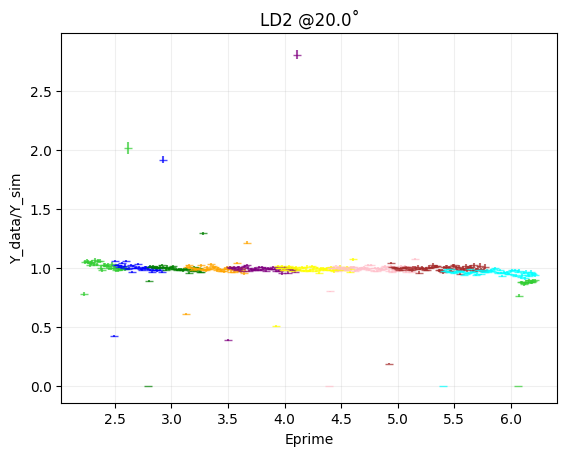

In [23]:
ratio_eprime_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
ratio_eprime_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
ratio_eprime_3p04 = eprime_bin_contents_3p04/bin_counts_eprime_3p04
ratio_eprime_3p4 = eprime_bin_contents_3p4/bin_counts_eprime_3p4
ratio_eprime_3p81 = eprime_bin_contents_3p81/bin_counts_eprime_3p81
ratio_eprime_4p27 = eprime_bin_contents_4p27/bin_counts_eprime_4p27
ratio_eprime_4p78 = eprime_bin_contents_4p78/bin_counts_eprime_4p78
ratio_eprime_5p36 = eprime_bin_contents_5p36/bin_counts_eprime_5p36
ratio_eprime_5p878 = eprime_bin_contents_5p878/bin_counts_eprime_5p878
ratio_eprime_6p6 = eprime_bin_contents_6p6/bin_counts_eprime_6p6

ratio_errors_2p42 = ratio_eprime_2p42 * np.sqrt((eprime_bin_errors_2p42/eprime_bin_contents_2p42)**2 + (bin_errors_eprime_2p42/bin_counts_eprime_2p42)**2)
ratio_errors_2p71 = ratio_eprime_2p71 * np.sqrt((eprime_bin_errors_2p71/eprime_bin_contents_2p71)**2 + (bin_errors_eprime_2p71/bin_counts_eprime_2p71)**2)
ratio_errors_3p04 = ratio_eprime_3p04 * np.sqrt((eprime_bin_errors_3p04/eprime_bin_contents_3p04)**2 + (bin_errors_eprime_3p04/bin_counts_eprime_3p04)**2)
ratio_errors_3p4 = ratio_eprime_3p4 * np.sqrt((eprime_bin_errors_3p4/eprime_bin_contents_3p4)**2 + (bin_errors_eprime_3p4/bin_counts_eprime_3p4)**2)
ratio_errors_3p81 = ratio_eprime_3p81 * np.sqrt((eprime_bin_errors_3p81/eprime_bin_contents_3p81)**2 + (bin_errors_eprime_3p81/bin_counts_eprime_3p81)**2)
ratio_errors_4p27 = ratio_eprime_4p27 * np.sqrt((eprime_bin_errors_4p27/eprime_bin_contents_4p27)**2 + (bin_errors_eprime_4p27/bin_counts_eprime_4p27)**2)
ratio_errors_4p78 = ratio_eprime_4p78 * np.sqrt((eprime_bin_errors_4p78/eprime_bin_contents_4p78)**2 + (bin_errors_eprime_4p78/bin_counts_eprime_4p78)**2)
ratio_errors_5p36 = ratio_eprime_5p36 * np.sqrt((eprime_bin_errors_5p36/eprime_bin_contents_5p36)**2 + (bin_errors_eprime_5p36/bin_counts_eprime_5p36)**2)
ratio_errors_5p878 = ratio_eprime_5p878 * np.sqrt((eprime_bin_errors_5p878/eprime_bin_contents_5p878)**2 + (bin_errors_eprime_5p878/bin_counts_eprime_5p878)**2)
ratio_errors_6p6 = ratio_eprime_6p6 * np.sqrt((eprime_bin_errors_6p6/eprime_bin_contents_6p6)**2 + (bin_errors_eprime_6p6/bin_counts_eprime_6p6)**2)

fig5, ax5 = plt.subplots()
ax5.errorbar(bin_centers_eprime_2p42, ratio_eprime_2p42, yerr = ratio_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax5.errorbar(bin_centers_eprime_2p71, ratio_eprime_2p71, yerr = ratio_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax5.errorbar(bin_centers_eprime_3p04, ratio_eprime_3p04, yerr = ratio_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax5.errorbar(bin_centers_eprime_3p4, ratio_eprime_3p4, yerr = ratio_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax5.errorbar(bin_centers_eprime_3p81, ratio_eprime_3p81, yerr = ratio_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax5.errorbar(bin_centers_eprime_4p27, ratio_eprime_4p27, yerr = ratio_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax5.errorbar(bin_centers_eprime_4p78, ratio_eprime_4p78, yerr = ratio_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax5.errorbar(bin_centers_eprime_5p36, ratio_eprime_5p36, yerr = ratio_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax5.errorbar(bin_centers_eprime_5p878, ratio_eprime_5p878, yerr = ratio_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax5.errorbar(bin_centers_eprime_6p6, ratio_eprime_6p6, yerr = ratio_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax5.set_xlabel('Eprime')
ax5.set_ylabel('Y_data/Y_sim')
ax5.set_title(f'{dtg} @{dang}˚')
ax5.grid(True, alpha = 0.2)
fig5.savefig(f'{folder}/ratio_eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR DTG</h1>


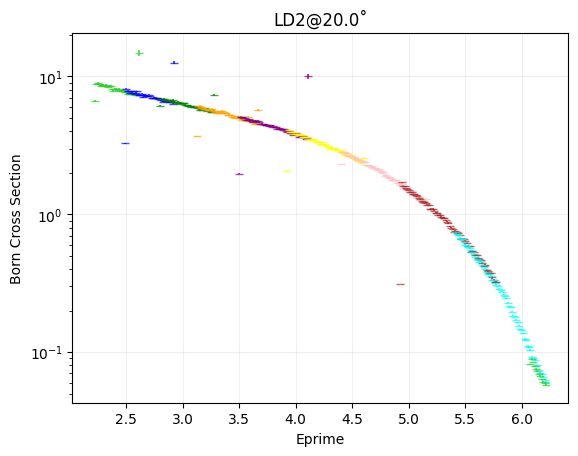

In [24]:
points_to_interpolate_2p42 = np.column_stack((bin_centers_eprime_2p42, np.full(len(bin_centers_eprime_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((bin_centers_eprime_2p71, np.full(len(bin_centers_eprime_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((bin_centers_eprime_3p04, np.full(len(bin_centers_eprime_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((bin_centers_eprime_3p4, np.full(len(bin_centers_eprime_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((bin_centers_eprime_3p81, np.full(len(bin_centers_eprime_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((bin_centers_eprime_4p27, np.full(len(bin_centers_eprime_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((bin_centers_eprime_4p78, np.full(len(bin_centers_eprime_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((bin_centers_eprime_5p36, np.full(len(bin_centers_eprime_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((bin_centers_eprime_5p878, np.full(len(bin_centers_eprime_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((bin_centers_eprime_6p6, np.full(len(bin_centers_eprime_6p6), dang)))

born_xsec_array_2p42 = griddata(points, V6, points_to_interpolate_2p42, method='linear')
born_xsec_array_2p71 = griddata(points, V6, points_to_interpolate_2p71, method='linear')
born_xsec_array_3p04 = griddata(points, V6, points_to_interpolate_3p04, method='linear')
born_xsec_array_3p4 = griddata(points, V6, points_to_interpolate_3p4, method='linear')
born_xsec_array_3p81 = griddata(points, V6, points_to_interpolate_3p81, method='linear')
born_xsec_array_4p27 = griddata(points, V6, points_to_interpolate_4p27, method='linear')
born_xsec_array_4p78 = griddata(points, V6, points_to_interpolate_4p78, method='linear')
born_xsec_array_5p36 = griddata(points, V6, points_to_interpolate_5p36, method='linear')
born_xsec_array_5p878 = griddata(points, V6, points_to_interpolate_5p878, method='linear')
born_xsec_array_6p6 = griddata(points, V6, points_to_interpolate_6p6, method='linear')

born_cross_2p42_dtg = ratio_eprime_2p42 * born_xsec_array_2p42
born_cross_2p71_dtg = ratio_eprime_2p71 * born_xsec_array_2p71
born_cross_3p04_dtg = ratio_eprime_3p04 * born_xsec_array_3p04
born_cross_3p4_dtg= ratio_eprime_3p4 * born_xsec_array_3p4
born_cross_3p81_dtg = ratio_eprime_3p81 * born_xsec_array_3p81
born_cross_4p27_dtg = ratio_eprime_4p27 * born_xsec_array_4p27
born_cross_4p78_dtg = ratio_eprime_4p78 * born_xsec_array_4p78
born_cross_5p36_dtg = ratio_eprime_5p36 * born_xsec_array_5p36
born_cross_5p878_dtg = ratio_eprime_5p878 * born_xsec_array_5p878
born_cross_6p6_dtg= ratio_eprime_6p6 * born_xsec_array_6p6

born_errors_2p42_dtg = born_cross_2p42_dtg * ratio_errors_2p42
born_errors_2p71_dtg = born_cross_2p71_dtg * ratio_errors_2p71
born_errors_3p04_dtg = born_cross_3p04_dtg * ratio_errors_3p04
born_errors_3p4_dtg = born_cross_3p4_dtg * ratio_errors_3p4
born_errors_3p81_dtg = born_cross_3p81_dtg * ratio_errors_3p81
born_errors_4p27_dtg = born_cross_4p27_dtg * ratio_errors_4p27
born_errors_4p78_dtg = born_cross_4p78_dtg * ratio_errors_4p78
born_errors_5p36_dtg = born_cross_5p36_dtg * ratio_errors_5p36
born_errors_5p878_dtg = born_cross_5p878_dtg * ratio_errors_5p878
born_errors_6p6_dtg = born_cross_6p6_dtg * ratio_errors_6p6

fig6, ax6 = plt.subplots()
ax6.errorbar(bin_centers_eprime_2p42, born_cross_2p42_dtg, yerr = born_errors_2p42_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax6.errorbar(bin_centers_eprime_2p71, born_cross_2p71_dtg, yerr = born_errors_2p71_dtg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax6.errorbar(bin_centers_eprime_3p04, born_cross_3p04_dtg, yerr = born_errors_3p04_dtg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax6.errorbar(bin_centers_eprime_3p4, born_cross_3p4_dtg, yerr = born_errors_3p4_dtg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax6.errorbar(bin_centers_eprime_3p81, born_cross_3p81_dtg, yerr = born_errors_3p81_dtg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax6.errorbar(bin_centers_eprime_4p27, born_cross_4p27_dtg, yerr = born_errors_4p27_dtg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax6.errorbar(bin_centers_eprime_4p78, born_cross_4p78_dtg, yerr = born_errors_4p78_dtg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax6.errorbar(bin_centers_eprime_5p36, born_cross_5p36_dtg, yerr = born_errors_5p36_dtg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax6.errorbar(bin_centers_eprime_5p878, born_cross_5p878_dtg, yerr = born_errors_5p878_dtg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax6.errorbar(bin_centers_eprime_6p6, born_cross_6p6_dtg, yerr = born_errors_6p6_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax6.set_xlabel('Eprime')
ax6.set_ylabel('Born Cross Section')
ax6.set_title(f'{dtg}@{dang}˚')
ax6.set_yscale('log')
#ax6.legend()
ax6.grid(True, alpha = 0.2)
fig6.savefig(f'{folder}/xsec_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">TAKING CROSS-SECTION RATIOS</h1>

Per-nucleon scaling factor: 4.5
slope -0.09622278950395327
high point 0.8541113071191881
low point 1.0573819499462895


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/2078308151.py:9: RuntimeWarning: invalid value encountered in divide
  csr_3p04 = born_cross_3p04_ntg/born_cross_3p04_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/2078308151.py:10: RuntimeWarning: invalid value encountered in divide
  csr_3p4 = born_cross_3p4_ntg/born_cross_3p4_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/2078308151.py:12: RuntimeWarning: invalid value encountered in divide
  csr_4p27 = born_cross_4p27_ntg/born_cross_4p27_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/2078308151.py:13: RuntimeWarning: invalid value encountered in divide
  csr_4p78 = born_cross_4p78_ntg/born_cross_4p78_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_7472/2078308151.py:14: RuntimeWarning: invalid value encountered in divide
  csr_5p36 = born_cross_5p36_ntg/born_cross_5p36_dtg/sf
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipyke

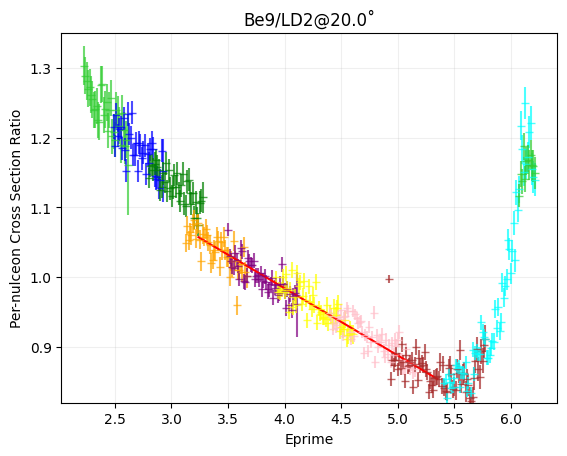

In [25]:
nA = 9
dA = 2

sf = nA/dA
print("Per-nucleon scaling factor:", sf)

csr_2p42 = born_cross_2p42_ntg/born_cross_2p42_dtg/sf
csr_2p71 = born_cross_2p71_ntg/born_cross_2p71_dtg/sf
csr_3p04 = born_cross_3p04_ntg/born_cross_3p04_dtg/sf
csr_3p4 = born_cross_3p4_ntg/born_cross_3p4_dtg/sf
csr_3p81 = born_cross_3p81_ntg/born_cross_3p81_dtg/sf
csr_4p27 = born_cross_4p27_ntg/born_cross_4p27_dtg/sf
csr_4p78 = born_cross_4p78_ntg/born_cross_4p78_dtg/sf
csr_5p36 = born_cross_5p36_ntg/born_cross_5p36_dtg/sf
csr_5p878 = born_cross_5p878_ntg/born_cross_5p878_dtg/sf
csr_6p6 = born_cross_6p6_ntg/born_cross_6p6_dtg/sf

csr_errors_2p42 = csr_2p42 * np.sqrt((born_errors_2p42_ntg/born_cross_2p42_ntg)**2 + (born_errors_2p42_dtg/born_cross_2p42_dtg)**2)
csr_errors_2p71 = csr_2p71 * np.sqrt((born_errors_2p71_ntg/born_cross_2p71_ntg)**2 + (born_errors_2p71_dtg/born_cross_2p71_dtg)**2)
csr_errors_3p04 = csr_3p04 * np.sqrt((born_errors_3p04_ntg/born_cross_3p04_ntg)**2 + (born_errors_3p04_dtg/born_cross_3p04_dtg)**2)
csr_errors_3p4 = csr_3p4 * np.sqrt((born_errors_3p4_ntg/born_cross_3p4_ntg)**2 + (born_errors_3p4_dtg/born_cross_3p4_dtg)**2)
csr_errors_3p81 = csr_3p81 * np.sqrt((born_errors_3p81_ntg/born_cross_3p81_ntg)**2 + (born_errors_3p81_dtg/born_cross_3p81_dtg)**2)
csr_errors_4p27 = csr_4p27 * np.sqrt((born_errors_4p27_ntg/born_cross_4p27_ntg)**2 + (born_errors_4p27_dtg/born_cross_4p27_dtg)**2)
csr_errors_4p78 = csr_4p78 * np.sqrt((born_errors_4p78_ntg/born_cross_4p78_ntg)**2 + (born_errors_4p78_dtg/born_cross_4p78_dtg)**2)
csr_errors_5p36 = csr_5p36 * np.sqrt((born_errors_5p36_ntg/born_cross_5p36_ntg)**2 + (born_errors_5p36_dtg/born_cross_5p36_dtg)**2)
csr_errors_5p878 = csr_5p878 * np.sqrt((born_errors_5p878_ntg/born_cross_5p878_ntg)**2 + (born_errors_5p878_dtg/born_cross_5p878_dtg)**2)
csr_errors_6p6 = csr_6p6 * np.sqrt((born_errors_6p6_ntg/born_cross_6p6_ntg)**2 + (born_errors_6p6_dtg/born_cross_6p6_dtg)**2)

fig7, ax7 = plt.subplots()
ax7.errorbar(bin_centers_eprime_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax7.errorbar(bin_centers_eprime_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax7.errorbar(bin_centers_eprime_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax7.errorbar(bin_centers_eprime_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax7.errorbar(bin_centers_eprime_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax7.errorbar(bin_centers_eprime_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax7.errorbar(bin_centers_eprime_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax7.errorbar(bin_centers_eprime_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax7.errorbar(bin_centers_eprime_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax7.errorbar(bin_centers_eprime_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax7.set_xlabel('Eprime')
ax7.set_ylabel('Per-nulceon Cross Section Ratio')
ax7.set_title(f'{ntg}/{dtg}@{dang}˚')
ax7.grid(True, alpha = 0.2)
ax7.set_ylim(0.82, 1.35)

csr = np.concatenate((csr_2p42, csr_2p71, csr_3p04, csr_3p4, csr_3p81, csr_4p27, csr_4p78, csr_5p36, csr_5p878, csr_6p6))
bin_centers = np.concatenate((bin_centers_eprime_2p42, bin_centers_eprime_2p71, bin_centers_eprime_3p04, bin_centers_eprime_3p4, bin_centers_eprime_3p81, bin_centers_eprime_4p27, bin_centers_eprime_4p78, bin_centers_eprime_5p36, bin_centers_eprime_5p878, bin_centers_eprime_6p6))
mask = (bin_centers >= 3.23) & (bin_centers <= 5.36) & ~np.isnan(csr)
filtered_csr = csr[mask]
filtered_bin_centers = bin_centers[mask]
# for i in range(len(filtered_csr)):
#     print(f"{filtered_bin_centers[i]} {filtered_csr[i]}")

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("slope", slope)
print("high point", slope*np.max(filtered_bin_centers) + intercept)
print("low point", slope*np.min(filtered_bin_centers) + intercept)
ax7.plot(filtered_bin_centers, slope*filtered_bin_centers + intercept, 'r')
fig7.savefig(f'{folder}/csr_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">Converting to Bjorken-x</h1>

absolute value of slope 0.5135271498611612
low point 0.8418283279196552
EMC Ratio at x=0.3: 1.0463000552209978


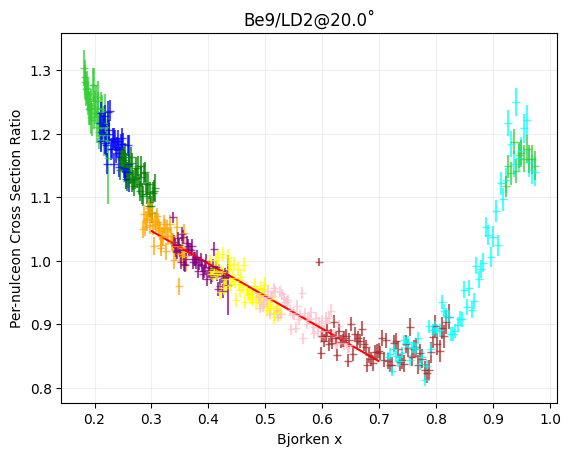

In [26]:
bin_centers_bjx_2p42 = (4 * Ei * bin_centers_eprime_2p42 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_2p42))
bin_centers_bjx_2p71 = (4 * Ei * bin_centers_eprime_2p71 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_2p71))
bin_centers_bjx_3p04 = (4 * Ei * bin_centers_eprime_3p04 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_3p04))
bin_centers_bjx_3p4 = (4 * Ei * bin_centers_eprime_3p4 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_3p4))
bin_centers_bjx_3p81 = (4 * Ei * bin_centers_eprime_3p81 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_3p81))
bin_centers_bjx_4p27 = (4 * Ei * bin_centers_eprime_4p27 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_4p27))
bin_centers_bjx_4p78 = (4 * Ei * bin_centers_eprime_4p78 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_4p78))
bin_centers_bjx_5p36 = (4 * Ei * bin_centers_eprime_5p36 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_5p36))
bin_centers_bjx_5p878 = (4 * Ei * bin_centers_eprime_5p878 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_5p878))
bin_centers_bjx_6p6 = (4 * Ei * bin_centers_eprime_6p6 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - bin_centers_eprime_6p6))

fig8, ax8 = plt.subplots()
ax8.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax8.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax8.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax8.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax8.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax8.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax8.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax8.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax8.errorbar(bin_centers_bjx_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax8.errorbar(bin_centers_bjx_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax8.set_xlabel('Bjorken x')
ax8.set_ylabel('Per-nulceon Cross Section Ratio')
ax8.set_title(f'{ntg}/{dtg}@{dang}˚')
ax8.grid(True, alpha = 0.2)

bjx_bin_centers = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
mask = (bjx_bin_centers >= 0.3) & (bjx_bin_centers <= 0.7) & ~np.isnan(csr)
filtered_bin_centers = bjx_bin_centers[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("absolute value of slope", abs(slope))
print("low point", slope*np.max(filtered_bin_centers) + intercept)
print("EMC Ratio at x=0.3:", slope*np.min(filtered_bin_centers) + intercept)
ax8.plot(filtered_bin_centers, slope*filtered_bin_centers + intercept, 'r')
fig8.savefig(f'{folder}/emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

In [27]:
confidence_level = 0.95

# Calculate degrees of freedom
df = len(filtered_bin_centers) - 2

# Find the t-value for the given confidence level and degrees of freedom
t_value = stats.t.ppf((1 + confidence_level) / 2, df)
print("t value", t_value)

# Calculate the confidence interval for the slope
ci_lower = slope - t_value * std_err
ci_upper = slope + t_value * std_err

print(f"The {confidence_level*100}% confidence interval for the slope is [{ci_lower}, {ci_upper}]")

t value 1.9699815295289813
The 95.0% confidence interval for the slope is [-0.5348919078858763, -0.49216239183644617]


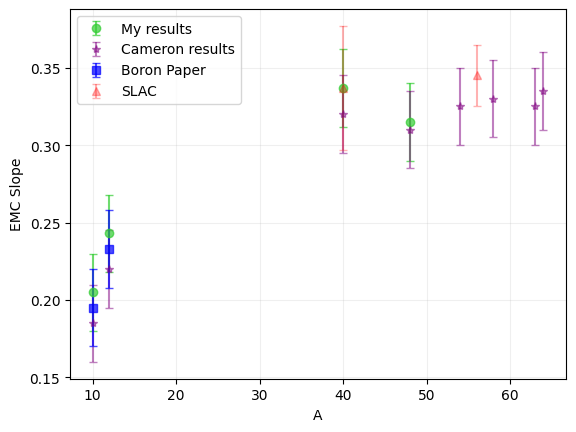

In [28]:
x = [10, 12, 40, 48]
y = [0.205, 0.243, 0.337, 0.315]
cam_x = [10, 12, 40, 48, 54, 58, 63, 64]
cam_y = [0.185, 0.22, 0.32, 0.31, 0.325, 0.33, 0.325, 0.335]
yerr = [0.025, 0.025, 0.025, 0.025]
cam_yerr = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
fig9, ax9 = plt.subplots()
ax9.errorbar(x, y, yerr = yerr, fmt = 'o', alpha = 0.7, color = 'limegreen', capsize = 3, label = 'My results')
ax9.errorbar(cam_x, cam_y, yerr = cam_yerr, fmt = '*', alpha = 0.5, color = 'purple', capsize = 3, label = 'Cameron results')
y2 = [0.195, 0.233]
x2 = [10, 12]
y3 = [0.337, 0.345]
x3 = [40, 56]
y2err = [0.025, 0.025]
y3err = [0.04, 0.02]
ax9.errorbar(x2, y2, yerr = y2err, fmt = 's', alpha = 0.7, color = 'blue', capsize = 3, label = 'Boron Paper')
ax9.errorbar(x3, y3, yerr = y3err, fmt = '^', alpha = 0.3, color = 'red', capsize = 3, label = 'SLAC')
ax9.set_xlabel('A')
ax9.set_ylabel('EMC Slope')
ax9.grid(True, alpha = 0.2)
ax9.legend(loc = 'upper left')
fig9.savefig(f'bjx/emc_comparison_{start_time}.pdf')

In [3]:
def jra_nprat(x,q2):
    xtab = np.array([0.010,0.020,0.030,0.040,0.050,0.060,0.070,0.080,0.090,0.100,0.110,0.120,0.130,0.140,0.150,0.160,0.170,0.180,0.190,0.200,0.210,0.220,0.230,0.240,0.250,0.260,0.270,0.280,0.290,0.300,0.310,0.320,0.330,0.340,0.350,0.360,0.370,0.380,0.390,0.400,0.410,0.420,0.430,0.440,0.450,0.460,0.470,0.480,0.490,0.500,0.510,0.520,0.530,0.540,0.550,0.560,0.570,0.580,0.590,0.600,0.610,0.620,0.630,0.640,0.650,0.660,0.670,0.680,0.690,0.700,0.710,0.720,0.730,0.740,0.750,0.760,0.770,0.780,0.790,0.800,0.810,0.820,0.830,0.840,0.850,0.860,0.870,0.880,0.890,0.900,0.910,0.920,0.930,0.940,0.950,0.960,0.970,0.980,0.990,1.000])

    q2tab = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,15.0])

    nonp=np.array([[0.983509E+00,0.967562E+00,0.952133E+00,0.937198E+00,
      0.922738E+00,0.908734E+00,0.895167E+00,0.882020E+00,0.869275E+00,
      0.856917E+00,0.844931E+00,0.833300E+00,0.822010E+00,0.811048E+00,
      0.800401E+00,0.790055E+00,0.779999E+00,0.770222E+00,0.760711E+00,
      0.751457E+00,0.742449E+00,0.733679E+00,0.725136E+00,0.716812E+00,
      0.708699E+00,0.700790E+00,0.693076E+00,0.685551E+00,0.678208E+00,
      0.671042E+00,0.664041E+00,0.657206E+00,0.650530E+00,0.644006E+00,
      0.637628E+00,0.631395E+00,0.625297E+00,0.619336E+00,0.613508E+00,
      0.607788E+00,0.602222E+00,0.596735E+00,0.591388E+00,0.586151E+00,
      0.581032E+00,0.575976E+00,0.571070E+00,0.566249E+00,0.561505E+00,
      0.556859E+00,0.552326E+00,0.547884E+00,0.543518E+00,0.539216E+00,
      0.535019E+00,0.530865E+00,0.526926E+00,0.522888E+00,0.518921E+00,
      0.515048E+00,0.511480E+00,0.507615E+00,0.504017E+00,0.500443E+00,
      0.497119E+00,0.493618E+00,0.490066E+00,0.486863E+00,0.483462E+00,
      0.480752E+00,0.477100E+00,0.473876E+00,0.471597E+00,0.468325E+00,
      0.465172E+00,0.463005E+00,0.459858E+00,0.457916E+00,0.452807E+00,
      0.450750E+00,0.451604E+00,0.446949E+00,0.438826E+00,0.443575E+00,
      0.444461E+00,0.436106E+00,0.428253E+00,0.432000E+00,0.436110E+00,
      0.426526E+00,0.417893E+00,0.421976E+00,0.433359E+00,0.412051E+00,
      0.425995E+00,0.426235E+00,0.414856E+00,0.419595E+00,0.414556E+00,
      0.457513E+00],
      [0.983509,0.967559,0.952119,0.937164,0.922671,0.908618,
      0.894987,0.881756,0.868907,0.856424,0.844289,0.832487,0.821001,
      0.809819,0.798926,0.788308,0.777955,0.767855,0.757995,0.748366,
      0.738959,0.729762,0.720769,0.711970,0.703358,0.694925,0.686665,
      0.678569,0.670634,0.662851,0.655216,0.647724,0.640369,0.633148,
      0.626055,0.619087,0.612238,0.605507,0.598888,0.592381,0.585978,
      0.579676,0.573483,0.567381,0.561373,0.555459,0.549643,0.543901,
      0.538247,0.532687,0.527185,0.521772,0.516424,0.511157,0.505953,
      0.500826,0.495763,0.490746,0.485828,0.480940,0.476151,0.471344,
      0.466696,0.462116,0.457552,0.452952,0.448466,0.444209,0.439813,
      0.435568,0.431184,0.427269,0.423081,0.419041,0.415156,0.410801,
      0.407098,0.403425,0.400097,0.395570,0.391607,0.389038,0.386063,
      0.381268,0.377802,0.374977,0.371842,0.368327,0.364838,0.362433,
      0.360181,0.353288,0.355565,0.350272,0.353403,0.343797,0.356637,
      0.354206,0.348619,0.313281],
      [0.983510,0.967561,0.952118,0.937157,
      0.922654,0.908587,0.894934,0.881676,0.868794,0.856270,0.844086,
      0.832226,0.820675,0.809418,0.798441,0.787732,0.777276,0.767064,
      0.757083,0.747323,0.737774,0.728427,0.719272,0.710302,0.701508,
      0.692884,0.684421,0.676114,0.667956,0.659941,0.652064,0.644319,
      0.636702,0.629208,0.621833,0.614572,0.607422,0.600379,0.593440,
      0.586600,0.579859,0.573212,0.566655,0.560190,0.553808,0.547511,
      0.541293,0.535154,0.529089,0.523092,0.517166,0.511309,0.505516,
      0.499776,0.494105,0.488500,0.482945,0.477457,0.472016,0.466636,
      0.461332,0.456062,0.450841,0.445676,0.440586,0.435560,0.430543,
      0.425598,0.420714,0.415880,0.411154,0.406366,0.401623,0.397016,
      0.392580,0.388002,0.383386,0.379056,0.374824,0.370799,0.366380,
      0.361443,0.357684,0.354736,0.350574,0.345649,0.342257,0.339736,
      0.333568,0.331548,0.328415,0.326729,0.320067,0.318466,0.316831,
      0.318958,0.307941,0.306496,0.314458,0.341841],
      [0.983511,0.967562,0.952118,0.937155,0.922648,0.908574,0.894911,
      0.881641,0.868742,0.856198,0.843990,0.832102,0.820519,0.809225,
      0.798207,0.787451,0.776944,0.766676,0.756634,0.746807,0.737187,
      0.727763,0.718526,0.709468,0.700581,0.691858,0.683291,0.674874,
      0.666600,0.658464,0.650460,0.642582,0.634826,0.627188,0.619662,
      0.612245,0.604933,0.597723,0.590610,0.583591,0.576664,0.569826,
      0.563074,0.556404,0.549815,0.543304,0.536865,0.530498,0.524198,
      0.517961,0.511786,0.505672,0.499617,0.493619,0.487675,0.481789,
      0.475957,0.470175,0.464451,0.458773,0.453154,0.447575,0.442062,
      0.436587,0.431165,0.425793,0.420489,0.415204,0.409975,0.404812,
      0.399690,0.394627,0.389593,0.384685,0.379695,0.374906,0.370107,
      0.365316,0.360556,0.355935,0.351579,0.346887,0.342370,0.337866,
      0.334286,0.329150,0.324774,0.321725,0.318475,0.312829,0.310749,
      0.309096,0.300508,0.302876,0.296301,0.297655,0.289021,0.289589,
      0.293994,0.314936],
      [0.983511,0.967564,0.952119,0.937155,0.922645,0.908567,0.894900,
      0.881622,0.868714,0.856158,0.843936,0.832031,0.820429,0.809113,
      0.798070,0.787287,0.776750,0.766448,0.756369,0.746503,0.736840,
      0.727370,0.718083,0.708972,0.700029,0.691246,0.682616,0.674131,
      0.665787,0.657576,0.649494,0.641535,0.633694,0.625966,0.618348,
      0.610834,0.603421,0.596106,0.588885,0.581754,0.574711,0.567753,
      0.560876,0.554079,0.547357,0.540709,0.534130,0.527617,0.521165,
      0.514775,0.508440,0.502162,0.495938,0.489768,0.483649,0.477581,
      0.471566,0.465599,0.459680,0.453810,0.447989,0.442215,0.436491,
      0.430812,0.425180,0.419597,0.414061,0.408569,0.403131,0.397743,
      0.392384,0.387107,0.381856,0.376672,0.371528,0.366410,0.361420,
      0.356439,0.351487,0.346606,0.341924,0.337194,0.332407,0.327782,
      0.323699,0.319170,0.314455,0.310125,0.307215,0.301642,0.298502,
      0.295424,0.289368,0.289307,0.284499,0.280933,0.277798,0.277803,
      0.280455,0.284791],
      [0.983512,0.967565,0.952120,0.937156,0.922644,0.908564,0.894893,
      0.881610,0.868696,0.856133,0.843902,0.831987,0.820372,0.809042,
      0.797983,0.787181,0.776624,0.766300,0.756197,0.746305,0.736613,
      0.727111,0.717792,0.708646,0.699665,0.690842,0.682169,0.673640,
      0.665248,0.656987,0.648852,0.640838,0.632939,0.625151,0.617470,
      0.609890,0.602409,0.595023,0.587727,0.580520,0.573398,0.566357,
      0.559396,0.552510,0.545697,0.538955,0.532279,0.525664,0.519108,
      0.512609,0.506164,0.499771,0.493430,0.487140,0.480898,0.474704,
      0.468557,0.462460,0.456407,0.450400,0.444440,0.438524,0.432654,
      0.426828,0.421050,0.415315,0.409625,0.403984,0.398382,0.392835,
      0.387346,0.381878,0.376478,0.371131,0.365850,0.360577,0.355399,
      0.350270,0.345240,0.340166,0.335218,0.330465,0.325688,0.320838,
      0.316225,0.311863,0.307204,0.302922,0.299101,0.294904,0.290491,
      0.287610,0.284479,0.279501,0.279012,0.274414,0.273407,0.272938,
      0.272034,0.276103],
      [0.983512,0.967566,0.952121,0.937156,0.922644,0.908562,0.894889,
      0.881603,0.868685,0.856116,0.843879,0.831956,0.820332,0.808992,
      0.797922,0.787107,0.776536,0.766196,0.756076,0.746165,0.736453,
      0.726930,0.717587,0.708416,0.699408,0.690556,0.681852,0.673291,
      0.664865,0.656569,0.648396,0.640342,0.632402,0.624571,0.616843,
      0.609217,0.601686,0.594248,0.586899,0.579636,0.572456,0.565356,
      0.558332,0.551383,0.544504,0.537692,0.530944,0.524256,0.517624,
      0.511045,0.504518,0.498042,0.491614,0.485235,0.478903,0.472616,
      0.466375,0.460178,0.454027,0.447919,0.441853,0.435834,0.429856,
      0.423923,0.418031,0.412188,0.406386,0.400631,0.394916,0.389253,
      0.383636,0.378070,0.372545,0.367084,0.361686,0.356316,0.351006,
      0.345767,0.340628,0.335499,0.330442,0.325487,0.320655,0.315780,
      0.311117,0.306730,0.302236,0.297676,0.293601,0.289589,0.285513,
      0.282426,0.279029,0.274611,0.273444,0.268930,0.269485,0.267128,
      0.266523,0.270773],
      [0.983512,0.967567,0.952122,0.937157,0.922644,0.908561,0.894886,
      0.881598,0.868677,0.856104,0.843862,0.831934,0.820304,0.808956,
      0.797877,0.787053,0.776472,0.766120,0.755987,0.746062,0.736335,
      0.726796,0.717435,0.708245,0.699217,0.690343,0.681617,0.673032,
      0.664580,0.656257,0.648056,0.639972,0.632001,0.624137,0.616375,
      0.608712,0.601144,0.593668,0.586278,0.578973,0.571749,0.564604,
      0.557533,0.550535,0.543605,0.536741,0.529939,0.523194,0.516503,
      0.509864,0.503275,0.496734,0.490241,0.483794,0.477391,0.471033,
      0.464719,0.458448,0.452220,0.446034,0.439890,0.433788,0.427729,
      0.421711,0.415736,0.409803,0.403917,0.398072,0.392272,0.386518,
      0.380816,0.375159,0.369550,0.363991,0.358501,0.353061,0.347664,
      0.342349,0.337116,0.331931,0.326810,0.321788,0.316898,0.312051,
      0.307267,0.302752,0.298231,0.293810,0.289751,0.285784,0.281724,
      0.278268,0.275267,0.271325,0.269301,0.266271,0.266834,0.263387,
      0.264002,0.267541],
      [0.983513,0.967568,0.952124,0.937158,0.922645,0.908561,0.894883,
      0.881592,0.868666,0.856088,0.843840,0.831904,0.820265,0.808907,
      0.797817,0.786980,0.776384,0.766016,0.755865,0.745921,0.736173,
      0.726611,0.717226,0.708009,0.698953,0.690050,0.681292,0.672672,
      0.664185,0.655824,0.647584,0.639458,0.631443,0.623532,0.615723,
      0.608009,0.600389,0.592857,0.585411,0.578046,0.570760,0.563550,
      0.556413,0.549346,0.542345,0.535406,0.528526,0.521701,0.514926,
      0.508201,0.501523,0.494891,0.488303,0.481759,0.475257,0.468797,
      0.462378,0.456000,0.449662,0.443364,0.437106,0.430889,0.424711,
      0.418574,0.412477,0.406423,0.400410,0.394441,0.388517,0.382636,
      0.376805,0.371023,0.365294,0.359616,0.353994,0.348441,0.342946,
      0.337513,0.332155,0.326902,0.321704,0.316604,0.311612,0.306770,
      0.301954,0.297360,0.292914,0.288574,0.284420,0.280509,0.277032,
      0.273768,0.270723,0.267774,0.265423,0.263488,0.263733,0.262517,
      0.260921,0.264691],
      [0.983514,0.967570,0.952126,0.937160,0.922646,0.908560,0.894880,
      0.881584,0.868654,0.856069,0.843813,0.831867,0.820216,0.808846,
      0.797740,0.786886,0.776271,0.765882,0.755708,0.745738,0.735962,
      0.726370,0.716953,0.707702,0.698609,0.689666,0.680866,0.672202,
      0.663667,0.655256,0.646963,0.638781,0.630707,0.622735,0.614861,
      0.607080,0.599389,0.591784,0.584260,0.576816,0.569447,0.562150,
      0.554923,0.547762,0.540664,0.533624,0.526639,0.519704,0.512816,
      0.505974,0.499175,0.492418,0.485701,0.479024,0.472386,0.465786,
      0.459224,0.452699,0.446211,0.439760,0.433346,0.426969,0.420630,
      0.414329,0.408066,0.401844,0.395662,0.389523,0.383428,0.377380,
      0.371379,0.365430,0.359536,0.353700,0.347925,0.342220,0.336589,
      0.331033,0.325563,0.320198,0.314934,0.309777,0.304761,0.299900,
      0.295185,0.290643,0.286344,0.282260,0.278380,0.274907,0.271685,
      0.268766,0.266372,0.264444,0.262996,0.262203,0.261550,0.261707,
       0.262413,0.261832]])

    if x<0.01 or x>=1:
        f2rat=1.0
        print('x out of range, setting f2rat to 1.0',x)
        return

    if q2<1.0 or q2>=15:
        f2rat=1.0
        print('q2 out of range, setting f2rat to 1.0',q2)
        return

    for i in range(99): # loop over x
        q2lo=0.0
        q2hi=0.0
        xlo=0.0
        xhi=0.0

        if (x>=xtab[i]) & (x<xtab[i+1]) :
            xhi=xtab[i+1]
            xlo=xtab[i]
            deltax=xhi-xlo
            for j in range(9): # loop over q2
                if (q2>=q2tab[j]) & (q2<q2tab[j+1]):
                    q2hi=q2tab[j+1]
                    q2lo=q2tab[j]
                    deltaq2=q2hi-q2lo

                    A1=nonp[j,i]
                    A2=nonp[j,i+1]
                    A3=nonp[j+1,i]
                    A4=nonp[j+1,i+1]

                    A12=(A1*(xhi-x) + A2*(x-xlo))/deltax
                    A34=(A3*(xhi-x) + A4*(x-xlo))/deltax
                    
                    A1234=(A12*(q2hi-q2)+A34*(q2-q2lo))/deltaq2
    # print('x,q2,f2rat:',x,q2)
    f2rat=A1234
    return f2rat

isoscalar_all = np.zeros(len(bin_centers_eprime_2p42))

q2_all = 4 * Ei * bin_centers_eprime_2p42 * (np.sin(dang * np.pi / 180 / 2))**2
i = 0

for i in range(len(bin_centers_eprime_2p42)):
    isoscalar_all[i] = jra_nprat(bin_centers_bjx_2p42[i], q2_all[i])
    i += 1

print("Average of q2_all", np.mean(q2_all))
print("Average of Bjorken x", np.mean(bin_centers_bjx_2p42))
print("Length and average of isoscalar_2p42", len(isoscalar_all), np.mean(isoscalar_all))

NameError: name 'bin_centers_eprime_2p42' is not defined

In [1]:
plt.plot(bin_centers_bjx_2p42, isoscalar_all, '_', color = 'green', alpha = 0.7)
plt.xlabel('Bjorken-x')
plt.ylabel("sigma_n/sigma_p")
plt.grid(alpha = 0.2)
print("csr_5p36", csr_5p36)

NameError: name 'plt' is not defined

Length of isoscalar_factor 320
Mean of isoscalar_factor 1.0367645294406427
absolute value of slope 0.5569166526831953
low point 0.7998538371823509
EMC Ratio at x=0.3: 1.021602015380528


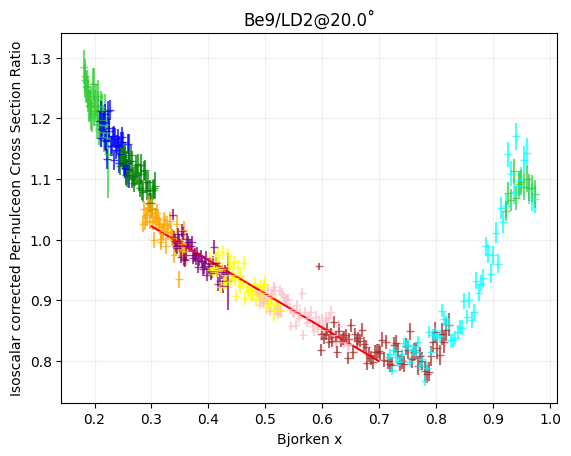

In [31]:
nZ = 4
nN = nA - nZ
isoscalar_factor = (nA/2 * (1 + isoscalar_all))/(nZ + (nN * isoscalar_all))
print("Length of isoscalar_factor", len(isoscalar_factor))
print("Mean of isoscalar_factor", np.mean(isoscalar_factor))

csr_2p42 = csr_2p42 * 1/isoscalar_factor
csr_2p71 = csr_2p71 * 1/isoscalar_factor
csr_3p04 = csr_3p04 * 1/isoscalar_factor
csr_3p4 = csr_3p4 * 1/isoscalar_factor
csr_3p81 = csr_3p81 * 1/isoscalar_factor
csr_4p27 = csr_4p27 * 1/isoscalar_factor
csr_4p78 = csr_4p78 * 1/isoscalar_factor
csr_5p36 = csr_5p36 * 1/isoscalar_factor
csr_5p878 = csr_5p878 * 1/isoscalar_factor
csr_6p6 = csr_6p6 * 1/isoscalar_factor

fig9, ax9 = plt.subplots()
ax9.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax9.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax9.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax9.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax9.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax9.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax9.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax9.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax9.errorbar(bin_centers_bjx_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax9.errorbar(bin_centers_bjx_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax9.set_xlabel('Bjorken x')
ax9.set_ylabel('Isoscalar corrected Per-nulceon Cross Section Ratio')
ax9.set_title(f'{ntg}/{dtg}@{dang}˚')
ax9.grid(True, alpha = 0.2)


csr = np.concatenate((csr_2p42, csr_2p71, csr_3p04, csr_3p4, csr_3p81, csr_4p27, csr_4p78, csr_5p36, csr_5p878, csr_6p6))
bjx_bin_centers = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
mask = (bjx_bin_centers >= 0.3) & (bjx_bin_centers <= 0.7) & ~np.isnan(csr)
filtered_bin_centers = bjx_bin_centers[mask]
filtered_csr = csr[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("absolute value of slope", abs(slope))
print("low point", slope*np.max(filtered_bin_centers) + intercept)
print("EMC Ratio at x=0.3:", slope*np.min(filtered_bin_centers) + intercept)
ax9.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
fig9.savefig(f'{folder}/isoscalarcorrected_emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

nA 9
Length of csr_2p42 320
Length of isoscalar_factor 320
csr_5p36 [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan      

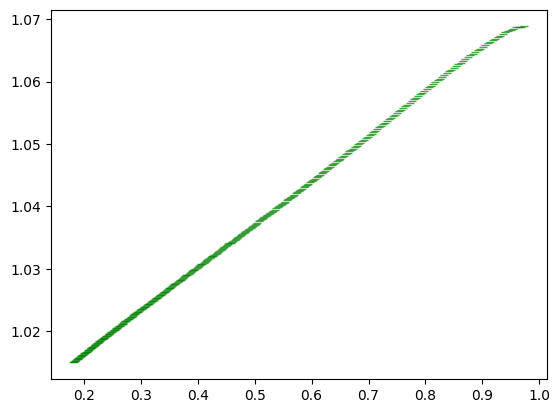

In [32]:
plt.plot(bin_centers_bjx_2p42, isoscalar_factor, '_', color = 'green', alpha = 0.7)
print("nA", nA)
print("Length of csr_2p42", len(csr_2p42))
print("Length of isoscalar_factor", len(isoscalar_factor))
print("csr_5p36", csr_5p36)